In [1]:
import os
import sys
sys.path.append(os.path.abspath("/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/"))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#from task import CreateDataLabel,MapAtomNode,node_accuracy
#from schnet import SchNetModel
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import wandb
import seaborn as sns

# Example code

In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="DL_tmp", #项目名称
    entity="transmembrane-topology", # 用户名
    group="batch_size", # 对比实验分组
    # name="test run ", #实验的名字
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "schnet",
    "dataset": "protein 3D structures ",
    "epochs":100,
    'batch_size':128


    }
)
sns.set_style("whitegrid")

NameError: ignored

In [ ]:

##['train', 'val', 'test_SP_TM', 'test_TM', 'test_BETA']
batch_size = 128
raw_data_name = "DeepTMHMM.3line"
#path ='/work3/s230027/DL/codebase/' # replace with your own path (the whole is '/work3/s230027/DL/codebase/sturcutre',it will find the graphy in the structure folder',you can change  '/you path/sturcutre')(you path = path)

path = '/content/drive/MyDrive/02456 Deep learning/schnet0.13/structure'
processor = CreateDataLabel(path,batch_size =batch_size,raw_data_name=raw_data_name)
# processor.initialization()# split and download trian/val/test just once
# train_data,train_lable, train_batchname, train_max_len,train_dismatch_index_pred,train_dismatch_index_type,train_real_node_label,df_train = processor.datalabelgenerator('train')

# val_data,val_lable, val_batchname, val_max_len,val_dismatch_index_pred,val_dismatch_index_type,val_real_node_label,df_val = processor.datalabelgenerator('val')

test_SP_TM_data,test_SP_TM_lable, test_SP_TM_batchname, test_SP_TM_max_len,test_SP_TM_dismatch_index_pred,test_SP_TM_dismatch_index_type,test_SP_TM_real_node_label,test_SP_TM_val = processor.datalabelgenerator('test_SP_TM')

test_TM_data,test_TM_lable, test_TM_batchname, test_TM_max_len,test_TM_dismatch_index_pred,test_TM_dismatch_index_type,test_TM_real_node_label,test_TM_val = processor.datalabelgenerator('test_TM')

test_BETA_data,test_BETA_lable, test_BETA_batchname, test_BETA_max_len,test_BETA_dismatch_index_pred,test_BETA_dismatch_index_type,test_BETA_real_node_label,test_BETA_val = processor.datalabelgenerator('test_BETA')

NameError: ignored

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_len=max(train_max_len,val_max_len,test_SP_TM_max_len,test_TM_max_len,test_BETA_max_len)+1 #StaticEmbedding need max_len
# !!! put model to GPU
model = SchNetModel(hidden_channels=128, out_dim=6, max_len=max_len).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
from torchinfo import summary

summary(model)

#

In [ ]:
total_epochs=200
draw_num = 1
global_step = 0


epoch_atom_level_accuracy_record_train = []
epoch_loss_record_train=[]
epoch_node_level_accuracy_record_train = []
epoch_atom_level_accuracy_record_val = []
epoch_loss_record_val = []
epoch_node_level_accuracy_record_val = []

for epoch in range(total_epochs):
    epoch_atom_level_accuracy_train = []
    epoch_loss_train=[]
    epoch_node_level_accuracy_train = []
    # train
    for i, data in enumerate(train_data):
        global_step += 1
        optimizer.zero_grad()
        outputs = model(data.to(device))   # put batch data in GPU get logits
        prediction = outputs["node_embedding"]
        real_label = torch.argmax(torch.tensor(train_lable[i]), dim=1).to(device) # put label in GPU
        loss = criterion(prediction, real_label)  # operate in the same device
        loss.backward()
        optimizer.step()

        #calulate atom-level accuracy and node-level accuracy
        _, predicted = torch.max(prediction, 1)
        correct = (predicted == real_label).sum().item()
        total = real_label.size(0)
        atom_level_accuracy =  correct / total

        # below is operated under CPU node
        processor = MapAtomNode(predicted.cpu(),train_batchname[i],train_dismatch_index_pred,train_dismatch_index_type,df_train)

        train_predict_node_label = processor.map_atom_node()
        node_level_accuracy = node_accuracy(train_predict_node_label,train_real_node_label[i])

        wandb.log({'train_loss':loss.item(), 'step':global_step})
        wandb.log({'train_atom_level_accuracy':atom_level_accuracy,  'step':global_step})
        wandb.log({'train_node_level_accuracy':node_level_accuracy, 'step':global_step})


        epoch_loss_train.append(loss.item())
        epoch_atom_level_accuracy_train.append(atom_level_accuracy)
        epoch_node_level_accuracy_train.append(node_level_accuracy)

    # global_step = 5, 10 ,15

    epoch_loss_record_train.append(np.mean(epoch_loss_train))
    epoch_atom_level_accuracy_record_train.append(np.mean(epoch_atom_level_accuracy_train))
    epoch_node_level_accuracy_record_train.append(np.mean(epoch_node_level_accuracy_train))



    #val
    model.eval()
    with torch.no_grad():

        epoch_atom_level_accuracy_val = []
        epoch_loss_val = []
        epoch_node_level_accuracy_val = []

        for i, data in enumerate(val_data):
            outputs = model(data.to(device))
            prediction = outputs["node_embedding"]
            real_label = torch.argmax(torch.tensor(val_lable[i]), dim=1).to(device)
            loss = criterion(prediction, real_label)


            _, predicted = torch.max(prediction, 1)
            correct = (predicted == real_label).sum().item()
            total = real_label.size(0)
            atom_level_accuracy = correct / total

            processor = MapAtomNode(predicted.cpu(), val_batchname[i], val_dismatch_index_pred, val_dismatch_index_type, df_val)
            val_predict_node_label = processor.map_atom_node()
            node_level_accuracy = node_accuracy(val_predict_node_label, val_real_node_label[i])

            epoch_loss_val.append(loss.item())
            epoch_atom_level_accuracy_val.append(atom_level_accuracy)
            epoch_node_level_accuracy_val.append(node_level_accuracy)





        epoch_loss_record_val.append(np.mean(epoch_loss_val))
        epoch_atom_level_accuracy_record_val.append(np.mean(epoch_atom_level_accuracy_val))
        epoch_node_level_accuracy_record_val.append(np.mean(epoch_node_level_accuracy_val))

        wandb.log({'val_loss':np.mean(epoch_loss_val), 'global_step':global_step})
        wandb.log({'val_atom_level_accuracy':np.mean(epoch_atom_level_accuracy_val), 'step':epoch+1})
        wandb.log({'val_node_level_accuracy':np.mean(epoch_node_level_accuracy_val), 'step':epoch+1})

    if epoch % draw_num == 0:
        print(f"EPOCH:{epoch}:Train Loss:{np.mean(epoch_loss_train)} Train Atom Level Accuracy:{np.mean(epoch_atom_level_accuracy_train)} Train Node Level Accuracy:{np.mean(epoch_node_level_accuracy_train)}")
        print(f"EPOCH:{epoch}:Val Loss:{np.mean(epoch_loss_val)} Val Atom Level Accuracy:{np.mean(epoch_atom_level_accuracy_val)} Val Node Level Accuracy:{np.mean(epoch_node_level_accuracy_val)}")


wandb.finish()


print("Finished training.")

torch.save(model.state_dict(), '/work3/s230027/DL/result/final_model.pth')


# Try predict the test data to test the model

In [4]:
# !pip install torch_geometric
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+${CUDA}.html
!pip install graphein

import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.8/309.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.9/191.9 kB 24.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.9/144.9 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.7 MB/s eta

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/')


from schnet import SchNetModel

[12/20/23 12:58:49] WARNING  To use the Graphein submodule                                         ]8;id=216495;file:///usr/local/lib/python3.10/dist-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=506985;file:///usr/local/lib/python3.10/dist-packages/graphein/protein/features/sequence/embeddings.py#44\44]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             To do so, use the following command: pip install biovec                               
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

                    WARNING  To use the Graphein submodule graphein.protein.visualisation, you  ]8;id=61070;file:///usr/local/lib/python3.10/dist-packages/graphein/protein/visualisation.py\visualisation.py]8;;\:]8;id=163428;file:///usr/local/lib/python3.10/dist-packages/graphein/protein/visualisation.py#35\35]8;;\
                             need to install: pytorch3d                                                            
                             pytorch3d cannot be installed via pip                                                 

[12/20/23 12:58:50] WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=559026;file:///usr/local/lib/python3.10/dist-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=179229;file:///usr/local/lib/python3.10/dist-packages/graphein/protein/meshes.py#29\29]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: pip install pytorch3d                            

In [ ]:
#!pip install omegaconf
#!pip install lightning
#!pip install beartype

In [6]:
#import os
#sys.path.append(os.path.abspath("/content/drive/MyDrive/02456 Deep learning/schnet0.13/base.py"))

from base import ProcessBatchData, AtomInfo
from task import CreateDataLabel, MapAtomNode

In [7]:
##['train', 'val', 'test_SP_TM', 'test_TM', 'test_BETA']
batch_size = 1
raw_data_name = "DeepTMHMM.3line"
#path ='/work3/s230027/DL/codebase/'
path = '/content/drive/MyDrive/02456 Deep learning/Model evaluation/'
processor = CreateDataLabel(path,batch_size =batch_size,raw_data_name=raw_data_name)
# processor.initialization()# split and download trian/val/test just once

train_data,train_lable, train_batchname, train_max_len,train_dismatch_index_pred,train_dismatch_index_type,train_real_node_label,df_train = processor.datalabelgenerator('train')

val_data,val_lable, val_batchname, val_max_len,val_dismatch_index_pred,val_dismatch_index_type,val_real_node_label,df_val = processor.datalabelgenerator('val')

test_SP_TM_data,test_SP_TM_lable, test_SP_TM_batchname, test_SP_TM_max_len,test_SP_TM_dismatch_index_pred,test_SP_TM_dismatch_index_type,test_SP_TM_real_node_label,df_test_SP_TM = processor.datalabelgenerator('test_SP_TM')

test_TM_data,test_TM_lable, test_TM_batchname, test_TM_max_len,test_TM_dismatch_index_pred,test_TM_dismatch_index_type,test_TM_real_node_label,df_test_TM = processor.datalabelgenerator('test_TM')

test_BETA_data,test_BETA_lable, test_BETA_batchname, test_BETA_max_len,test_BETA_dismatch_index_pred,test_BETA_dismatch_index_type,test_BETA_real_node_label,df_test_BETA = processor.datalabelgenerator('test_BETA')

[12/20/23 12:58:53] INFO     Amending traindata                                                          task.py:78

[12/20/23 12:59:09] INFO     Found 2381 examples in train                                         data_utils.py:307

Finding dismatch and processing ...: 100%|██████████| 2381/2381 [00:12<00:00, 191.23it/s]


[12/20/23 13:03:52] INFO     Have finshed finding dismatch and processing, after processing not   data_utils.py:143
                             founded dismatch                                                                      

                    INFO     Processing train data                                                       task.py:82

Structure Analysis Using Geometric: 100%|██████████| 2381/2381 [00:54<00:00, 43.96it/s]


[12/20/23 13:08:04] INFO     Processing train labels                                                     task.py:87

[12/20/23 13:08:06] INFO     Found 2381 examples in train                                         data_utils.py:307

Processing train atom label: 100%|██████████| 2381/2381 [00:01<00:00, 2177.40it/s]


[12/20/23 13:08:09] INFO     Amending valdata                                                            task.py:78

[12/20/23 13:08:10] INFO     Found 596 examples in val                                            data_utils.py:307

Finding dismatch and processing ...: 100%|██████████| 596/596 [00:02<00:00, 251.30it/s]


[12/20/23 13:09:17] INFO     Have finshed finding dismatch and processing, after processing not   data_utils.py:143
                             founded dismatch                                                                      

                    INFO     Processing val data                                                         task.py:82

Structure Analysis Using Geometric: 100%|██████████| 596/596 [00:12<00:00, 46.24it/s]


[12/20/23 13:10:17] INFO     Processing val labels                                                       task.py:87

                    INFO     Found 596 examples in val                                            data_utils.py:307

Processing val atom label: 100%|██████████| 596/596 [00:00<00:00, 2318.70it/s]


[12/20/23 13:10:18] INFO     Amending test_SP_TMdata                                                     task.py:78

                    INFO     Found 102 examples in test_SP_TM                                     data_utils.py:307

Finding dismatch and processing ...: 100%|██████████| 102/102 [00:00<00:00, 209.26it/s]


[12/20/23 13:10:36] INFO     Have finshed finding dismatch and processing, after processing not   data_utils.py:143
                             founded dismatch                                                                      

                    INFO     Processing test_SP_TM data                                                  task.py:82

Structure Analysis Using Geometric: 100%|██████████| 102/102 [00:02<00:00, 34.80it/s]


[12/20/23 13:10:50] INFO     Processing test_SP_TM labels                                                task.py:87

                    INFO     Found 102 examples in test_SP_TM                                     data_utils.py:307

Processing test_SP_TM atom label: 100%|██████████| 102/102 [00:00<00:00, 1650.94it/s]


                    INFO     Amending test_TMdata                                                        task.py:78

                    INFO     Found 382 examples in test_TM                                        data_utils.py:307

Finding dismatch and processing ...: 100%|██████████| 382/382 [00:01<00:00, 260.61it/s]


[12/20/23 13:11:31] INFO     Have finshed finding dismatch and processing, after processing not   data_utils.py:143
                             founded dismatch                                                                      

                    INFO     Processing test_TM data                                                     task.py:82

Structure Analysis Using Geometric: 100%|██████████| 382/382 [00:08<00:00, 43.46it/s]


[12/20/23 13:12:11] INFO     Processing test_TM labels                                                   task.py:87

                    INFO     Found 382 examples in test_TM                                        data_utils.py:307

Processing test_TM atom label: 100%|██████████| 382/382 [00:00<00:00, 2379.56it/s]


                    INFO     Amending test_BETAdata                                                      task.py:78

[12/20/23 13:12:12] INFO     Found 81 examples in test_BETA                                       data_utils.py:307

Finding dismatch and processing ...: 100%|██████████| 81/81 [00:00<00:00, 232.06it/s]


[12/20/23 13:12:40] INFO     Have finshed finding dismatch and processing, after processing not   data_utils.py:143
                             founded dismatch                                                                      

                    INFO     Processing test_BETA data                                                   task.py:82

Structure Analysis Using Geometric: 100%|██████████| 81/81 [00:02<00:00, 33.54it/s]


[12/20/23 13:12:50] INFO     Processing test_BETA labels                                                 task.py:87

                    INFO     Found 81 examples in test_BETA                                       data_utils.py:307

Processing test_BETA atom label: 100%|██████████| 81/81 [00:00<00:00, 1979.90it/s]


In [ ]:
len(train_batchname)

2381

# Find the CVs and regroup them

In [8]:
import json

# Opening JSON file
f = open('/content/drive/MyDrive/02456 Deep learning/Project/course project materials/DeepTMHMM.partitions.json')

# returns JSON object as
# a dictionary
cv_data = json.load(f)

cv0 = cv_data['cv0']
cv1 = cv_data['cv1']
cv2 = cv_data['cv2']
cv3 = cv_data['cv3']
cv4 = cv_data['cv4']

## Merge all datasets into one

In [9]:
import pandas as pd
frames = [df_train, df_val, df_test_SP_TM, df_test_TM, df_test_BETA]
total_df = pd.concat(frames)

total_data = train_data.copy()
total_label = train_lable.copy()
total_batchname = train_batchname.copy()
total_max_len = train_max_len + val_max_len + test_SP_TM_max_len + test_TM_max_len + test_BETA_max_len
total_dismatch_index_pred = train_dismatch_index_pred.copy()
total_dismatch_index_type = train_dismatch_index_type.copy()
total_real_node_label = train_real_node_label.copy()


#train_data,train_lable, train_batchname, train_max_len,train_dismatch_index_pred,train_dismatch_index_type,train_real_node_label,df_train
#test_SP_TM_data,test_SP_TM_lable, test_SP_TM_batchname, test_SP_TM_max_len,test_SP_TM_dismatch_index_pred,test_SP_TM_dismatch_index_type,test_SP_TM_real_node_label,test_SP_TM_val
#test_TM_data,test_TM_lable, test_TM_batchname, test_TM_max_len,test_TM_dismatch_index_pred,test_TM_dismatch_index_type,test_TM_real_node_label,test_TM_val
#test_BETA_data,test_BETA_lable, test_BETA_batchname, test_BETA_max_len,test_BETA_dismatch_index_pred,test_BETA_dismatch_index_type,test_BETA_real_node_label,test_BETA_val
for i in range(0, len(val_data)):
  total_data.append(val_data[i])
  total_label.append(val_lable[i])
  total_batchname.append(val_batchname[i])
  total_dismatch_index_pred[list(val_dismatch_index_pred)[i]] = list(val_dismatch_index_pred.values())[i]
  total_dismatch_index_type[list(val_dismatch_index_type)[i]] = list(val_dismatch_index_type.values())[i]
  total_real_node_label.append(val_real_node_label[i])


for i in range(0, len(test_SP_TM_data)):
  total_data.append(test_SP_TM_data[i])
  total_label.append(test_SP_TM_lable[i])
  total_batchname.append(test_SP_TM_batchname[i])
  total_dismatch_index_pred[list(test_SP_TM_dismatch_index_pred)[i]] = list(test_SP_TM_dismatch_index_pred.values())[i]
  total_dismatch_index_type[list(test_SP_TM_dismatch_index_type)[i]] = list(test_SP_TM_dismatch_index_type.values())[i]
  total_real_node_label.append(test_SP_TM_real_node_label[i])


for i in range(0, len(test_TM_data)):
  total_data.append(test_TM_data[i])
  total_label.append(test_TM_lable[i])
  total_batchname.append(test_TM_batchname[i])
  total_dismatch_index_pred[list(test_TM_dismatch_index_pred)[i]] = list(test_TM_dismatch_index_pred.values())[i]
  total_dismatch_index_type[list(test_TM_dismatch_index_type)[i]] = list(test_TM_dismatch_index_type.values())[i]
  total_real_node_label.append(test_TM_real_node_label[i])


for i in range(0, len(test_BETA_data)):
  total_data.append(test_BETA_data[i])
  total_label.append(test_BETA_lable[i])
  total_batchname.append(test_BETA_batchname[i])
  total_dismatch_index_pred[list(test_BETA_dismatch_index_pred)[i]] = list(test_BETA_dismatch_index_pred.values())[i]
  total_dismatch_index_type[list(test_BETA_dismatch_index_type)[i]] = list(test_BETA_dismatch_index_type.values())[i]
  total_real_node_label.append(test_BETA_real_node_label[i])



In [ ]:
print(list(total_dismatch_index_pred)[3]) # key
print(list(total_dismatch_index_pred.values())[3]) # value


q7tsh3
[8752]


In [ ]:
# len(total_data)
# len(cv0)
print(type(total_data))
print(type(total_label))
print(type(total_batchname))
print(type(total_dismatch_index_pred))
print(type(total_dismatch_index_type))
print(type(total_real_node_label))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'dict'>
<class 'dict'>
<class 'list'>


In [ ]:
cv0[0]['id'].lower()

'p10384'

In [ ]:
len(total_data[0].x)

11659

In [ ]:
#total_df.iloc[0]["uniprot_id"]


#total_df.loc[[total_df.iloc[0]["uniprot_id"]]]


#list(total_df.loc[[total_df.iloc[0]["uniprot_id"]]])

test = [total_df.loc[[total_df.iloc[0]["uniprot_id"]]]['seq'], total_df.loc[[total_df.iloc[0]["uniprot_id"]]]['raw_label'], total_df.loc[[total_df.iloc[0]["uniprot_id"]]]['protein_type'], total_df.loc[[total_df.iloc[0]["uniprot_id"]]]['atom_length'], total_df.loc[[total_df.iloc[0]["uniprot_id"]]]['atom_label'], total_df.loc[[total_df.iloc[0]["uniprot_id"]]]['uniprot_id'], total_df.loc[[total_df.iloc[0]["uniprot_id"]]]['uniprot_id_low'], total_df.loc[[total_df.iloc[0]["uniprot_id"]]]['seq_length']]

print(test[0])

MASQVVLSFALVVVLAVFVGQVDSCPSDCKCDYRSSQCRPANDDVHPNVCIDHYCVVMNLAKREQRPELSPGALDDSSEEKDNEASLA


In [ ]:
test =  pd.DataFrame(columns=total_df.columns)
test

,seq,raw_label,protein_type,atom_length,atom_label,uniprot_id,uniprot_id_low,seq_length


In [ ]:
test = pd.concat([test, total_df.loc[[total_df.iloc[0]["uniprot_id"]]]], ignore_index=False)
test

,seq,raw_label,protein_type,atom_length,atom_label,uniprot_id,uniprot_id_low,seq_length
A0A023W145,MASQVVLSFALVVVLAVFVGQVDSCPSDCKCDYRSSQCRPANDDVH...,[SSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOO...,SIGNAL,665,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 7, 6,...",A0A023W145,a0a023w145,88


In [ ]:
total_df

,seq,raw_label,protein_type,atom_length,atom_label,uniprot_id,uniprot_id_low,seq_length
A0A023W145,MASQVVLSFALVVVLAVFVGQVDSCPSDCKCDYRSSQCRPANDDVH...,[SSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOO...,SIGNAL,665,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 7, 6,...",A0A023W145,a0a023w145,88
A0A024B7I0,MAYMCADSGNLMAIAQQVIKQKQQQEQQQQQSHHPQQQFLGLNPFS...,[IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,GLOBULAR,4570,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 7, 6,...",A0A024B7I0,a0a024b7i0,588
A0A0D1DWQ2,MKLSVSIFVLLAVSAFGGGSAAAVSGKSEAAEIEAGDRLDALRDQL...,[SSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOO...,SIGNAL,2245,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 6, 6,...",A0A0D1DWQ2,a0a0d1dwq2,290
A0A0F7YZQ7,MAPSQKALLVLVLSMLLTASDSWARRIDCKVFVFAPICRGVAAKRG...,[SSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOO...,SIGNAL,775,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 7, 6,...",A0A0F7YZQ7,a0a0f7yzq7,100
A0A0K8P8E7,MQTTVTTMLLASVALAACAGGGSTPLPLPQQQPPQQEPPPPPVPLA...,[SSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,SIGNAL,4433,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 6, 6,...",A0A0K8P8E7,a0a0k8p8e7,603
...,...,...,...,...,...,...,...,...
Q9JZN9,MAQTTLKPIVLSILLINTPLLAQAHETEQSVDLETVSVVGKSRPRA...,[SSSSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPPPPP...,BETA,6019,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 7, 6,...",Q9JZN9,q9jzn9,758
Q9K0U7,MPTMGAEMNTRNMRYILLTGLLPMASAFGETALQCAALTDNVTRLA...,[SSSSSSSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPP...,BETA,3007,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 6, 6,...",Q9K0U7,q9k0u7,382
Q9K0U9,MQQQHLFRFNILCLSLMTALPAYAENVQAGQAQEKQLDTIQVKAKK...,[SSSSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPPPPP...,BETA,7215,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 6, 6,...",Q9K0U9,q9k0u9,915
Q9RP17,MKKALATLIALALPAAALAEGASGFYVQADAAHAKASSSLGSAKGF...,[SSSSSSSSSSSSSSSSSSSPPPPPPBBBBBBBBBBBBBOOOBBBB...,BETA,1300,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 6, 6,...",Q9RP17,q9rp17,174


## Redistribute the data into CVs

### trials

In [ ]:
[total_df.index[total_df['uniprot_id_low'] == cv0[i]['id'].lower()].tolist()[0].lower()]

['q8n5m9']

In [ ]:
total_data[cv0_index[0]]

DataBatch(x=[3438], pos=[3438, 3], batch=[3438], ptr=[2], edge_index=[2, 109397], edge_weight=[109397])

In [ ]:
len(total_label[cv0_index[0]])

3438

In [ ]:
cv0_batchname[0:10]

[['p10384'],
 ['p0abu7'],
 ['q55210'],
 ['q5xkl5'],
 ['q9kdp2'],
 ['q9cc87'],
 ['q7tqm5'],
 ['q2ydf6'],
 ['p10163'],
 ['q12286']]

In [ ]:
total_df.index[['p10384'.upper()]]

IndexError: ignored

In [ ]:
total_df.index[total_df['uniprot_id_low'] == cv0_batchname[0][0]][0]

'P10384'

In [ ]:
total_df.loc[cv0_batchname[0][0].upper()]

seq               MSQKTLFTKSALAVAVALISTQAWSAGFQLNEFSSSGLGRAYSGEG...
raw_label         [SSSSSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPPPP...
protein_type                                                   BETA
atom_length                                                    3437
atom_label        [7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 8, 7,...
uniprot_id                                                   P10384
uniprot_id_low                                               p10384
seq_length                                                      446
Name: P10384, dtype: object

In [ ]:
total_df.loc[cv0_batchname[0][0].upper()]

seq               MSQKTLFTKSALAVAVALISTQAWSAGFQLNEFSSSGLGRAYSGEG...
raw_label         [SSSSSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPPPP...
protein_type                                                   BETA
atom_length                                                    3437
atom_label        [7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 8, 7,...
uniprot_id                                                   P10384
uniprot_id_low                                               p10384
seq_length                                                      446
Name: P10384, dtype: object

### For cv0

In [10]:
# For cv0
cv0_data = []
cv0_label = []
cv0_batchname = []
cv0_dismatch_index_pred = {}
cv0_dismatch_index_type = {}
cv0_real_node_label = []
cv0_index = []
cv0_df = pd.DataFrame(columns=total_df.columns)

# The batch names have the same order as the data
for i in range(0, len(cv0)):
  try:
    #cv0_index.append(total_batchname.index([cv0[i]['id'].lower()]))
    cv0_batchname.append([total_df.index[total_df['uniprot_id_low'] == cv0[i]['id'].lower()].tolist()[0].lower()])
  except:
    pass
    #print(cv0[i]['id'].lower() + "is missing for cv0.")


# Find index for the found cv0 proteins
# Note that the labels are aligned with the batch names
for i in range(0, len(cv0)):
  try:
    cv0_index.append(total_batchname.index([cv0[i]['id'].lower()]))
  except:
    pass


# gather the data for cv0
for i in range(0, len(cv0_index)):
  cv0_data.append(total_data[cv0_index[i]])
  cv0_label.append(total_label[cv0_index[i]])
  cv0_dismatch_index_pred[list(total_dismatch_index_pred)[cv0_index[i]]] = list(total_dismatch_index_pred.values())[cv0_index[i]]
  cv0_dismatch_index_type[list(total_dismatch_index_type)[cv0_index[i]]] = list(total_dismatch_index_type.values())[cv0_index[i]]
  cv0_real_node_label.append(total_real_node_label[cv0_index[i]])

  #cv0_df = pd.concat([cv0_df, total_df.loc[[total_df.iloc[cv0_index[i]]["uniprot_id"]]]], ignore_index=False)
  cv0_df = pd.concat([cv0_df, total_df.loc[[cv0_batchname[i][0].upper()]]], ignore_index=False)

# put into a list
cv0_lis = [cv0_data, cv0_label, cv0_batchname, cv0_dismatch_index_pred, cv0_dismatch_index_type, cv0_real_node_label, cv0_df]





# for cv1
cv1_data = []
cv1_label = []
cv1_batchname = []
cv1_dismatch_index_pred = {}
cv1_dismatch_index_type = {}
cv1_real_node_label = []
cv1_index = []
cv1_df = pd.DataFrame(columns=total_df.columns)

# The batch names have the same order as the data
for i in range(0, len(cv1)):
  try:
    cv1_batchname.append([total_df.index[total_df['uniprot_id_low'] == cv1[i]['id'].lower()].tolist()[0].lower()])
  except:
    pass

# Find index for the found cv1 proteins
# Note that the labels are aligned with the batch names
for i in range(0, len(cv1)):
  try:
    cv1_index.append(total_batchname.index([cv1[i]['id'].lower()]))
  except:
    pass
    #print(cv1[i]['id'].lower() + "is missing for cv1.")


# gather the data for cv1
for i in range(0, len(cv1_index)):
  cv1_data.append(total_data[cv1_index[i]])
  cv1_label.append(total_label[cv1_index[i]])
  cv1_dismatch_index_pred[list(total_dismatch_index_pred)[cv1_index[i]]] = list(total_dismatch_index_pred.values())[cv1_index[i]]
  cv1_dismatch_index_type[list(total_dismatch_index_type)[cv1_index[i]]] = list(total_dismatch_index_type.values())[cv1_index[i]]
  cv1_real_node_label.append(total_real_node_label[cv1_index[i]])
  cv1_df = pd.concat([cv1_df, total_df.loc[[cv1_batchname[i][0].upper()]]], ignore_index=False)


# put into a list
cv1_lis = [cv1_data, cv1_label, cv1_batchname, cv1_dismatch_index_pred, cv1_dismatch_index_type, cv1_real_node_label, cv1_df]



# for cv2
cv2_data = []
cv2_label = []
cv2_batchname = []
cv2_dismatch_index_pred = {}
cv2_dismatch_index_type = {}
cv2_real_node_label = []
cv2_index = []
cv2_df = pd.DataFrame(columns=total_df.columns)

# The batch names have the same order as the data
for i in range(0, len(cv2)):
  try:
    cv2_batchname.append([total_df.index[total_df['uniprot_id_low'] == cv2[i]['id'].lower()].tolist()[0].lower()])
  except:
    pass
    #print(cv2[i]['id'].lower() + "is missing for cv2.")


# Find index for the found cv2 proteins
# Note that the labels are aligned with the batch names
for i in range(0, len(cv2)):
  try:
    cv2_index.append(total_batchname.index([cv2[i]['id'].lower()]))
  except:
    pass




# gather the data for cv2
for i in range(0, len(cv2_index)):
  cv2_data.append(total_data[cv2_index[i]])
  cv2_label.append(total_label[cv2_index[i]])
  cv2_dismatch_index_pred[list(total_dismatch_index_pred)[cv2_index[i]]] = list(total_dismatch_index_pred.values())[cv2_index[i]]
  cv2_dismatch_index_type[list(total_dismatch_index_type)[cv2_index[i]]] = list(total_dismatch_index_type.values())[cv2_index[i]]
  cv2_real_node_label.append(total_real_node_label[cv2_index[i]])
  cv2_df = pd.concat([cv2_df, total_df.loc[[cv2_batchname[i][0].upper()]]], ignore_index=False)


# put into a list
cv2_lis = [cv2_data, cv2_label, cv2_batchname, cv2_dismatch_index_pred, cv2_dismatch_index_type, cv2_real_node_label, cv2_df]




# for cv3
cv3_data = []
cv3_label = []
cv3_batchname = []
cv3_dismatch_index_pred = {}
cv3_dismatch_index_type = {}
cv3_real_node_label = []
cv3_index = []
cv3_df = pd.DataFrame(columns=total_df.columns)
# The batch names have the same order as the data
for i in range(0, len(cv3)):
  try:
    cv3_batchname.append([total_df.index[total_df['uniprot_id_low'] == cv3[i]['id'].lower()].tolist()[0].lower()])
  except:
    pass
    #print(cv3[i]['id'].lower() + "is missing for cv3.")


# Find index for the found cv3 proteins
# Note that the labels are aligned with the batch names
for i in range(0, len(cv3)):
  try:
    cv3_index.append(total_batchname.index([cv3[i]['id'].lower()]))
  except:
    pass

# gather the data for cv3
for i in range(0, len(cv3_index)):
  cv3_data.append(total_data[cv3_index[i]])
  cv3_label.append(total_label[cv3_index[i]])
  cv3_dismatch_index_pred[list(total_dismatch_index_pred)[cv3_index[i]]] = list(total_dismatch_index_pred.values())[cv3_index[i]]
  cv3_dismatch_index_type[list(total_dismatch_index_type)[cv3_index[i]]] = list(total_dismatch_index_type.values())[cv3_index[i]]
  cv3_real_node_label.append(total_real_node_label[cv3_index[i]])
  cv3_df = pd.concat([cv3_df, total_df.loc[[cv3_batchname[i][0].upper()]]], ignore_index=False)


# put into a list
cv3_lis = [cv3_data, cv3_label, cv3_batchname, cv3_dismatch_index_pred, cv3_dismatch_index_type, cv3_real_node_label, cv3_df]




# for cv4
cv4_data = []
cv4_label = []
cv4_batchname = []
cv4_dismatch_index_pred = {}
cv4_dismatch_index_type = {}
cv4_real_node_label = []
cv4_index = []
cv4_df = pd.DataFrame(columns=total_df.columns)
# The batch names have the same order as the data
for i in range(0, len(cv4)):
  try:
    cv4_batchname.append([total_df.index[total_df['uniprot_id_low'] == cv4[i]['id'].lower()].tolist()[0].lower()])
  except:
    pass
    #print(cv4[i]['id'].lower() + "is missing for cv4.")


# Find index for the found cv4 proteins
# Note that the labels are aligned with the batch names
for i in range(0, len(cv4)):
  try:
    cv4_index.append(total_batchname.index([cv4[i]['id'].lower()]))
  except:
    pass

# gather the data for cv4
for i in range(0, len(cv4_index)):
  cv4_data.append(total_data[cv4_index[i]])
  cv4_label.append(total_label[cv4_index[i]])
  cv4_dismatch_index_pred[list(total_dismatch_index_pred)[cv4_index[i]]] = list(total_dismatch_index_pred.values())[cv4_index[i]]
  cv4_dismatch_index_type[list(total_dismatch_index_type)[cv4_index[i]]] = list(total_dismatch_index_type.values())[cv4_index[i]]
  cv4_real_node_label.append(total_real_node_label[cv4_index[i]])
  cv4_df = pd.concat([cv4_df, total_df.loc[[cv4_batchname[i][0].upper()]]], ignore_index=False)


# put into a list
cv4_lis = [cv4_data, cv4_label, cv4_batchname, cv4_dismatch_index_pred, cv4_dismatch_index_type, cv4_real_node_label, cv4_df]


In [ ]:
len_str = "["
for i in range(0, len(cv4_data)):
  len_str += str(len(cv4_data[i].x)) + ","

len_str = len_str[0:-1]
len_str += "]"
print(len_str)

print(len(cv0_data), len(cv1_data), len(cv2_data), len(cv3_data), len(cv4_data))

[2494,6795,1923,9592,734,3095,7511,661,2244,541,5225,5436,3085,1571,12622,2538,2208,4141,5452,4517,5774,1024,2580,3954,7662,3691,18657,2784,2164,519,1178,9916,1863,3000,2844,1208,1158,2614,8170,1768,3107,2235,616,5282,4558,5587,3674,3876,2253,7633,3477,1697,6997,4895,4592,1070,2438,20118,3192,1258,5817,1002,4016,3502,2544,10460,12521,4328,3511,2757,5800,3478,1987,7948,2718,1623,3776,6537,1688,5429,1445,12598,1362,4058,992,7411,2278,3292,2555,1527,447,2088,575,3755,561,3419,1900,5685,3299,3296,4108,478,11256,1343,5036,1138,1252,2517,2381,1380,589,2958,5525,5474,4015,2987,2268,2353,5468,1791,5244,1360,11746,2888,2009,3856,2656,4338,12816,1982,2494,7767,2398,1227,885,10191,4128,3758,3795,3354,5264,1838,3262,7508,9367,1564,1578,11871,657,1182,1257,3723,6359,2586,5014,4071,5191,2586,6776,3359,1721,4012,2300,1985,2233,5766,2598,5930,7645,1139,3141,2703,2335,421,505,1101,2792,1082,3659,4468,1401,2035,1589,2036,2899,2083,1101,1866,2586,955,541,2967,14330,4645,2289,2934,3222,3160,4571,6750,3564

In [ ]:
total_df.tail()

,seq,raw_label,protein_type,atom_length,atom_label,uniprot_id,uniprot_id_low,seq_length
Q9JZN9,MAQTTLKPIVLSILLINTPLLAQAHETEQSVDLETVSVVGKSRPRA...,[SSSSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPPPPP...,BETA,6019,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 7, 6,...",Q9JZN9,q9jzn9,758
Q9K0U7,MPTMGAEMNTRNMRYILLTGLLPMASAFGETALQCAALTDNVTRLA...,[SSSSSSSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPP...,BETA,3007,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 6, 6,...",Q9K0U7,q9k0u7,382
Q9K0U9,MQQQHLFRFNILCLSLMTALPAYAENVQAGQAQEKQLDTIQVKAKK...,[SSSSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPPPPP...,BETA,7215,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 6, 6,...",Q9K0U9,q9k0u9,915
Q9RP17,MKKALATLIALALPAAALAEGASGFYVQADAAHAKASSSLGSAKGF...,[SSSSSSSSSSSSSSSSSSSPPPPPPBBBBBBBBBBBBBOOOBBBB...,BETA,1300,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 6, 6,...",Q9RP17,q9rp17,174
V6ALN4,MSRQSTDTAVSSQRLLASAIGVAITAIAAPQAAHADEAGQKKTDKD...,[SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPP...,BETA,5908,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 8, 7,...",V6ALN4,v6aln4,766


In [ ]:
cv0_df.tail()

,seq,raw_label,protein_type,atom_length,atom_label,uniprot_id,uniprot_id_low,seq_length
A6LFT2,MKWYLWGAVVLLYSLFGSACSTEWRYDLSAYGLSPVENVDNAPAMA...,[SSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOO...,SIGNAL,4909,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 6, 6,...",A6LFT2,a6lft2,612
Q9LT27,MSLVCSLSCVAPLPQTKQSRPSFLKLETCTLSLSSPAGYPNFTTGI...,[IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,GLOBULAR,2520,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 8, 7,...",Q9LT27,q9lt27,321
Q94JU3,MDIEQKQAEIIDQLVKRASTCKSEALGPLIIEATSHPSLFAFSEIL...,[IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,GLOBULAR,2064,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 6, 8,...",Q94JU3,q94ju3,260
P39744,MGKVSKSTKKFQSKHLKHTLDQRRKEKIQKKRIQGRRGNKTDQEKA...,[IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,GLOBULAR,5738,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 8, 7, 6, 6,...",P39744,p39744,710
Q8N5M9,MASRAGPRAAGTDGSDFQHRERVAMHYQMSVTLKYEIKKLIYVHLV...,[IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMM...,TM,1490,"[7, 6, 6, 6, 8, 6, 16, 6, 7, 6, 6, 6, 8, 7, 6,...",Q8N5M9,q8n5m9,183


# CV setup 1

## For train set

In [11]:
#cv0, cv1, cv2 for train, cv3 for validation, cv4 for test

setup1_train_data = cv0_data.copy()
setup1_train_label = cv0_label.copy()
setup1_train_batchname = cv0_batchname.copy()
setup1_train_dismatch_index_pred = cv0_dismatch_index_pred.copy()
setup1_train_dismatch_index_type = cv0_dismatch_index_type.copy()
setup1_train_real_node_label = cv0_real_node_label.copy()

setup1_train_df = [cv0_df, cv1_df, cv2_df]
setup1_train_df = pd.concat(setup1_train_df)


# cv0_data = []
# cv0_label = []
# cv0_batchname = []
# cv0_dismatch_index_pred = {}
# cv0_dismatch_index_type = {}
# cv0_real_node_label = []
# cv0_index = []
# cv0_df = []


for i in range(0, len(cv1_data)):
  setup1_train_data.append(cv1_data[i])
  setup1_train_label.append(cv1_label[i])
  setup1_train_batchname.append(cv1_batchname[i])
  setup1_train_dismatch_index_pred[list(cv1_dismatch_index_pred)[i]] = list(cv1_dismatch_index_pred.values())[i]
  setup1_train_dismatch_index_type[list(cv1_dismatch_index_type)[i]] = list(cv1_dismatch_index_type.values())[i]
  setup1_train_real_node_label.append(cv1_real_node_label[i])


for i in range(0, len(cv2_data)):
  setup1_train_data.append(cv2_data[i])
  setup1_train_label.append(cv2_label[i])
  setup1_train_batchname.append(cv2_batchname[i])
  setup1_train_dismatch_index_pred[list(cv2_dismatch_index_pred)[i]] = list(cv2_dismatch_index_pred.values())[i]
  setup1_train_dismatch_index_type[list(cv2_dismatch_index_type)[i]] = list(cv2_dismatch_index_type.values())[i]
  setup1_train_real_node_label.append(cv2_real_node_label[i])





In [ ]:
setup1_train_df['uniprot_id_low']

P10384    p10384
P0ABU7    p0abu7
Q55210    q55210
Q5XKL5    q5xkl5
Q9KDP2    q9kdp2
           ...  
P00992    p00992
Q9H0R1    q9h0r1
P82281    p82281
P34116    p34116
Q9S713    q9s713
Name: uniprot_id_low, Length: 2127, dtype: object

In [ ]:
#df_val[df_val['uniprot_id_low'] == val_batchname[0][0]]['seq'][0]

#cv0_df[cv0_df['uniprot_id_low'] == cv0_batchname[0][0]]['seq'][0]

#df_val['uniprot_id_low'] == val_batchname[0][0]

#df_val[df_val['uniprot_id_low'] == val_batchname[500][0]]['seq']

cv0_df[cv0_df['uniprot_id_low'] == cv0_batchname[600][0]]['seq']

#total_df[total_df['uniprot_id_low'] == total_batchname[500][0]]['seq']

P07102    MKAILIPFLSLLIPLTPQSAFAQSEPELKLESVVIVSRHGVRAPTK...
Name: seq, dtype: object

In [ ]:
# check setup1_train_df
for i in range(0, len(setup1_train_df)):
  setup1_train_df[setup1_train_df['uniprot_id_low'] == setup1_train_batchname[i][0]]['seq'][0]


In [ ]:
# Find max len

max_len = 0
for i in range(0, len(setup1_train_data)):
  if len(setup1_train_data[i]['x']) > max_len:
    max_len = len(setup1_train_data[i]['x'])

print(max_len)

20789


## Put all this into a function

In [12]:
def make_splits(cv0_lis, cv1_lis, cv2_lis, cv3_lis, cv4_lis, setup):

  # for setup 1:
  #cv0, cv1, cv2 for train, cv3 for validation, cv4 for test
  if setup == "setup 1":
  # data format
  #cv0_lis = [cv0_data, cv0_label, cv0_batchname, cv0_dismatch_index_pred, cv0_dismatch_index_type, cv0_real_node_label, cv0_df]

    setup_train_data = cv0_lis[0].copy()
    setup_train_label = cv0_lis[1].copy()
    setup_train_batchname = cv0_lis[2].copy()
    setup_train_dismatch_index_pred = cv0_lis[3].copy()
    setup_train_dismatch_index_type = cv0_lis[4].copy()
    setup_train_real_node_label = cv0_lis[5].copy()

    setup_train_df = [cv0_lis[6], cv1_lis[6], cv2_lis[6]]
    setup_train_df = pd.concat(setup_train_df)


    for i in range(0, len(cv1_lis[0])):
      setup_train_data.append(cv1_lis[0][i])
      setup_train_label.append(cv1_lis[1][i])
      setup_train_batchname.append(cv1_lis[2][i])
      setup_train_dismatch_index_pred[list(cv1_lis[3])[i]] = list(cv1_lis[3].values())[i]
      setup_train_dismatch_index_type[list(cv1_lis[4])[i]] = list(cv1_lis[4].values())[i]
      setup_train_real_node_label.append(cv1_lis[5][i])


    for i in range(0, len(cv2_lis[0])):
      setup_train_data.append(cv2_lis[0][i])
      setup_train_label.append(cv2_lis[1][i])
      setup_train_batchname.append(cv2_lis[2][i])
      setup_train_dismatch_index_pred[list(cv2_lis[3])[i]] = list(cv2_lis[3].values())[i]
      setup_train_dismatch_index_type[list(cv2_lis[4])[i]] = list(cv2_lis[4].values())[i]
      setup_train_real_node_label.append(cv2_lis[5][i])


    # The validation set
    setup_val_data = cv3_lis[0].copy()
    setup_val_label = cv3_lis[1].copy()
    setup_val_batchname = cv3_lis[2].copy()
    setup_val_dismatch_index_pred = cv3_lis[3].copy()
    setup_val_dismatch_index_type = cv3_lis[4].copy()
    setup_val_real_node_label = cv3_lis[5].copy()
    setup_val_df = cv3_lis[6].copy()


    # The test set
    setup_test_data = cv4_lis[0].copy()
    setup_test_label = cv4_lis[1].copy()
    setup_test_batchname = cv4_lis[2].copy()
    setup_test_dismatch_index_pred = cv4_lis[3].copy()
    setup_test_dismatch_index_type = cv4_lis[4].copy()
    setup_test_real_node_label = cv4_lis[5].copy()
    setup_test_df = cv4_lis[6].copy()










  # for setup 2: cv1, cv2, cv3 for train, cv4 for validation, cv0 for test
  elif setup == "setup 2":
    setup_train_data = cv1_lis[0].copy()
    setup_train_label = cv1_lis[1].copy()
    setup_train_batchname = cv1_lis[2].copy()
    setup_train_dismatch_index_pred = cv1_lis[3].copy()
    setup_train_dismatch_index_type = cv1_lis[4].copy()
    setup_train_real_node_label = cv1_lis[5].copy()

    setup_train_df = [cv1_lis[6], cv2_lis[6], cv3_lis[6]]
    setup_train_df = pd.concat(setup_train_df)


    for i in range(0, len(cv2_lis[0])):
      setup_train_data.append(cv2_lis[0][i])
      setup_train_label.append(cv2_lis[1][i])
      setup_train_batchname.append(cv2_lis[2][i])
      setup_train_dismatch_index_pred[list(cv2_lis[3])[i]] = list(cv2_lis[3].values())[i]
      setup_train_dismatch_index_type[list(cv2_lis[4])[i]] = list(cv2_lis[4].values())[i]
      setup_train_real_node_label.append(cv2_lis[5][i])


    for i in range(0, len(cv3_lis[0])):
      setup_train_data.append(cv3_lis[0][i])
      setup_train_label.append(cv3_lis[1][i])
      setup_train_batchname.append(cv3_lis[2][i])
      setup_train_dismatch_index_pred[list(cv3_lis[3])[i]] = list(cv3_lis[3].values())[i]
      setup_train_dismatch_index_type[list(cv3_lis[4])[i]] = list(cv3_lis[4].values())[i]
      setup_train_real_node_label.append(cv3_lis[5][i])


    # The validation set
    setup_val_data = cv4_lis[0].copy()
    setup_val_label = cv4_lis[1].copy()
    setup_val_batchname = cv4_lis[2].copy()
    setup_val_dismatch_index_pred = cv4_lis[3].copy()
    setup_val_dismatch_index_type = cv4_lis[4].copy()
    setup_val_real_node_label = cv4_lis[5].copy()
    setup_val_df = cv4_lis[6].copy()


    # The test set
    setup_test_data = cv0_lis[0].copy()
    setup_test_label = cv0_lis[1].copy()
    setup_test_batchname = cv0_lis[2].copy()
    setup_test_dismatch_index_pred = cv0_lis[3].copy()
    setup_test_dismatch_index_type = cv0_lis[4].copy()
    setup_test_real_node_label = cv0_lis[5].copy()
    setup_test_df = cv0_lis[6].copy()







  # for setup 3: cv2, cv3, cv4 for train, cv0 for validation, cv1 for test
  elif setup == "setup 3":
    setup_train_data = cv2_lis[0].copy()
    setup_train_label = cv2_lis[1].copy()
    setup_train_batchname = cv2_lis[2].copy()
    setup_train_dismatch_index_pred = cv2_lis[3].copy()
    setup_train_dismatch_index_type = cv2_lis[4].copy()
    setup_train_real_node_label = cv2_lis[5].copy()

    setup_train_df = [cv2_lis[6], cv3_lis[6], cv4_lis[6]]
    setup_train_df = pd.concat(setup_train_df)


    for i in range(0, len(cv3_lis[0])):
      setup_train_data.append(cv3_lis[0][i])
      setup_train_label.append(cv3_lis[1][i])
      setup_train_batchname.append(cv3_lis[2][i])
      setup_train_dismatch_index_pred[list(cv3_lis[3])[i]] = list(cv3_lis[3].values())[i]
      setup_train_dismatch_index_type[list(cv3_lis[4])[i]] = list(cv3_lis[4].values())[i]
      setup_train_real_node_label.append(cv3_lis[5][i])


    for i in range(0, len(cv4_lis[0])):
      setup_train_data.append(cv4_lis[0][i])
      setup_train_label.append(cv4_lis[1][i])
      setup_train_batchname.append(cv4_lis[2][i])
      setup_train_dismatch_index_pred[list(cv4_lis[3])[i]] = list(cv4_lis[3].values())[i]
      setup_train_dismatch_index_type[list(cv4_lis[4])[i]] = list(cv4_lis[4].values())[i]
      setup_train_real_node_label.append(cv4_lis[5][i])


    # The validation set
    setup_val_data = cv0_lis[0].copy()
    setup_val_label = cv0_lis[1].copy()
    setup_val_batchname = cv0_lis[2].copy()
    setup_val_dismatch_index_pred = cv0_lis[3].copy()
    setup_val_dismatch_index_type = cv0_lis[4].copy()
    setup_val_real_node_label = cv0_lis[5].copy()
    setup_val_df = cv0_lis[6].copy()


    # The test set
    setup_test_data = cv1_lis[0].copy()
    setup_test_label = cv1_lis[1].copy()
    setup_test_batchname = cv1_lis[2].copy()
    setup_test_dismatch_index_pred = cv1_lis[3].copy()
    setup_test_dismatch_index_type = cv1_lis[4].copy()
    setup_test_real_node_label = cv1_lis[5].copy()
    setup_test_df = cv1_lis[6].copy()







  # for setup 4: cv3, cv4, cv0 for train, cv1 for validation, cv2 for test
  elif setup == "setup 4":
    setup_train_data = cv3_lis[0].copy()
    setup_train_label = cv3_lis[1].copy()
    setup_train_batchname = cv3_lis[2].copy()
    setup_train_dismatch_index_pred = cv3_lis[3].copy()
    setup_train_dismatch_index_type = cv3_lis[4].copy()
    setup_train_real_node_label = cv3_lis[5].copy()

    setup_train_df = [cv3_lis[6], cv4_lis[6], cv0_lis[6]]
    setup_train_df = pd.concat(setup_train_df)


    for i in range(0, len(cv4_lis[0])):
      setup_train_data.append(cv4_lis[0][i])
      setup_train_label.append(cv4_lis[1][i])
      setup_train_batchname.append(cv4_lis[2][i])
      setup_train_dismatch_index_pred[list(cv4_lis[3])[i]] = list(cv4_lis[3].values())[i]
      setup_train_dismatch_index_type[list(cv4_lis[4])[i]] = list(cv4_lis[4].values())[i]
      setup_train_real_node_label.append(cv4_lis[5][i])


    for i in range(0, len(cv0_lis[0])):
      setup_train_data.append(cv0_lis[0][i])
      setup_train_label.append(cv0_lis[1][i])
      setup_train_batchname.append(cv0_lis[2][i])
      setup_train_dismatch_index_pred[list(cv0_lis[3])[i]] = list(cv0_lis[3].values())[i]
      setup_train_dismatch_index_type[list(cv0_lis[4])[i]] = list(cv0_lis[4].values())[i]
      setup_train_real_node_label.append(cv0_lis[5][i])


    # The validation set
    setup_val_data = cv1_lis[0].copy()
    setup_val_label = cv1_lis[1].copy()
    setup_val_batchname = cv1_lis[2].copy()
    setup_val_dismatch_index_pred = cv1_lis[3].copy()
    setup_val_dismatch_index_type = cv1_lis[4].copy()
    setup_val_real_node_label = cv1_lis[5].copy()
    setup_val_df = cv1_lis[6].copy()


    # The test set
    setup_test_data = cv2_lis[0].copy()
    setup_test_label = cv2_lis[1].copy()
    setup_test_batchname = cv2_lis[2].copy()
    setup_test_dismatch_index_pred = cv2_lis[3].copy()
    setup_test_dismatch_index_type = cv2_lis[4].copy()
    setup_test_real_node_label = cv2_lis[5].copy()
    setup_test_df = cv2_lis[6].copy()






  # for setup 5: cv4, cv0, cv1 for train, cv2 for validation, cv3 for test
  elif setup == "setup 5":
    setup_train_data = cv4_lis[0].copy()
    setup_train_label = cv4_lis[1].copy()
    setup_train_batchname = cv4_lis[2].copy()
    setup_train_dismatch_index_pred = cv4_lis[3].copy()
    setup_train_dismatch_index_type = cv4_lis[4].copy()
    setup_train_real_node_label = cv4_lis[5].copy()

    setup_train_df = [cv4_lis[6], cv0_lis[6], cv1_lis[6]]
    setup_train_df = pd.concat(setup_train_df)


    for i in range(0, len(cv0_lis[0])):
      setup_train_data.append(cv0_lis[0][i])
      setup_train_label.append(cv0_lis[1][i])
      setup_train_batchname.append(cv0_lis[2][i])
      setup_train_dismatch_index_pred[list(cv0_lis[3])[i]] = list(cv0_lis[3].values())[i]
      setup_train_dismatch_index_type[list(cv0_lis[4])[i]] = list(cv0_lis[4].values())[i]
      setup_train_real_node_label.append(cv0_lis[5][i])


    for i in range(0, len(cv1_lis[0])):
      setup_train_data.append(cv1_lis[0][i])
      setup_train_label.append(cv1_lis[1][i])
      setup_train_batchname.append(cv1_lis[2][i])
      setup_train_dismatch_index_pred[list(cv1_lis[3])[i]] = list(cv1_lis[3].values())[i]
      setup_train_dismatch_index_type[list(cv1_lis[4])[i]] = list(cv1_lis[4].values())[i]
      setup_train_real_node_label.append(cv1_lis[5][i])


    # The validation set
    setup_val_data = cv2_lis[0].copy()
    setup_val_label = cv2_lis[1].copy()
    setup_val_batchname = cv2_lis[2].copy()
    setup_val_dismatch_index_pred = cv2_lis[3].copy()
    setup_val_dismatch_index_type = cv2_lis[4].copy()
    setup_val_real_node_label = cv2_lis[5].copy()
    setup_val_df = cv2_lis[6].copy()


    # The test set
    setup_test_data = cv3_lis[0].copy()
    setup_test_label = cv3_lis[1].copy()
    setup_test_batchname = cv3_lis[2].copy()
    setup_test_dismatch_index_pred = cv3_lis[3].copy()
    setup_test_dismatch_index_type = cv3_lis[4].copy()
    setup_test_real_node_label = cv3_lis[5].copy()
    setup_test_df = cv3_lis[6].copy()



  return setup_train_data, setup_train_label, setup_train_batchname, setup_train_dismatch_index_pred, setup_train_dismatch_index_type, setup_train_real_node_label, setup_train_df, \
  setup_val_data, setup_val_label, setup_val_batchname, setup_val_dismatch_index_pred, setup_val_dismatch_index_type, setup_val_real_node_label, setup_val_df, \
  setup_test_data, setup_test_label, setup_test_batchname, setup_test_dismatch_index_pred, setup_test_dismatch_index_type, setup_test_real_node_label, setup_test_df



In [13]:
setup_train_data, setup_train_label, setup_train_batchname, setup_train_dismatch_index_pred, setup_train_dismatch_index_type, setup_train_real_node_label, setup_train_df, \
  setup_val_data, setup_val_label, setup_val_batchname, setup_val_dismatch_index_pred, setup_val_dismatch_index_type, setup_val_real_node_label, setup_val_df,\
  setup_test_data, setup_test_label, setup_test_batchname, setup_test_dismatch_index_pred, setup_test_dismatch_index_type, setup_test_real_node_label, setup_test_df = make_splits(cv0_lis, cv1_lis, cv2_lis, cv3_lis, cv4_lis, "setup 1")

In [ ]:
# verify the function

# print(setup_train_data == setup1_train_data)
# print(setup_train_label == setup1_train_label)
# print(setup_train_batchname ==  setup1_train_batchname)
# print(setup_train_dismatch_index_pred == setup1_train_dismatch_index_pred)
# print(setup_train_dismatch_index_type == setup1_train_dismatch_index_type)
# print(setup_train_real_node_label == setup1_train_real_node_label)
# print(setup_train_df.equals(setup1_train_df))


print(setup_val_data == cv2_lis[0])
print(setup_val_label == cv2_lis[1])
print(setup_val_batchname ==  cv2_lis[2])
print(setup_val_dismatch_index_pred == cv2_lis[3])
print(setup_val_dismatch_index_type == cv2_lis[4])
print(setup_val_real_node_label == cv2_lis[5])
print(setup_val_df.equals(cv2_lis[6]))

print(setup_test_data == cv3_lis[0])
print(setup_test_label == cv3_lis[1])
print(setup_test_batchname ==  cv3_lis[2])
print(setup_test_dismatch_index_pred == cv3_lis[3])
print(setup_test_dismatch_index_type == cv3_lis[4])
print(setup_test_real_node_label == cv3_lis[5])
print(setup_test_df.equals(cv3_lis[6]))

False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [ ]:
count = 0
for i in range(0, len(setup_train_label)):

  if not (setup_train_label[i] == setup1_train_label[i]) and count < 5:
    print(setup_train_label[i])
    print(setup1_train_label[i], '\n')
  else:
    continue

  count += 1

# Load model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# put model to GPU
max_length = 30000
#device = torch.device('cuda')
#device = torch.device('cpu')
model = SchNetModel(hidden_channels=128, out_dim=6, max_len=30000, max_num_neighbors=32).to(device)
criterion = nn.CrossEntropyLoss()
# Try with MSE loss
#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003,weight_decay=1e-4)


# Load state CV setup 1
#check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup1_neighbors_Gauss_big_kernel_setup1.pth', map_location=torch.device('cuda'))

# Load state CV setup 2
#check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup2_Gauss_result.pth', map_location=torch.device('cuda'))

# Load state CV setup 3
#check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup3_Gauss_result.pth', map_location=torch.device('cuda'))

# Load state CV setup 4
#check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup4_Gauss_result.pth', map_location=torch.device('cuda'))

# Load state CV setup 5
check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup5_Gauss_result.pth', map_location=torch.device('cuda'))


model.load_state_dict(check_point)
model.eval()

SchNetModel(hidden_channels=128, num_filters=128, num_interactions=6, num_gaussians=50, cutoff=10)

In [ ]:
print(type(prediction))
print(prediction.requires_grad)

smoothed = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3))
print(type(smoothed))
print(smoothed.to(device).requires_grad)


smoothed2 = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3)).clone().detach().requires_grad_(True)

print(smoothed2.to(device).requires_grad)

NameError: ignored

In [ ]:
smoothed2

tensor([[ 0.4661, -1.3327, -2.4450, -2.3868, -4.8783, -8.3315],
        [ 0.4034, -1.5203, -2.6936, -2.6326, -5.3321, -8.9305],
        [ 0.3172, -1.6334, -2.8268, -2.7726, -5.4733, -9.0145],
        ...,
        [ 2.0086,  0.5557, -1.3356, -2.9707, -4.8937, -6.3537],
        [ 2.6715,  0.7248, -1.6631, -3.2483, -4.9572, -6.5715],
        [ 2.0604,  0.6463, -1.1749, -2.6931, -4.5482, -6.0860]],
       requires_grad=True)

In [14]:
# Try a torch implementation of Gaussian smoothing
# from: https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/10
import math
import numbers
import torch
from torch import nn
from torch.nn import functional as F

class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)


smoothing = GaussianSmoothing(3, 5, 1)
input = torch.rand(1, 3, 100, 100)
input = F.pad(input, (2, 2, 2, 2), mode='reflect')
output = smoothing(input)


#smoothing = GaussianSmoothing(1, 7, 1)
# predicted = torch.reshape(prediction.to('cpu'), (1, 1, prediction.shape[1], prediction.shape[0]))
# predicted = F.pad(predicted, (3, 3, 3, 3), mode='reflect')
# predicted = smoothing(predicted)
# output = torch.reshape(predicted, (prediction.shape[0], prediction.shape[1]))


# >>> t4d = torch.empty(3, 3, 4, 2)
# >>> p1d = (1, 1) # pad last dim by 1 on each side
# >>> out = F.pad(t4d, p1d, "reflect", 0)
print(input.shape)

torch.Size([1, 3, 104, 104])


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)



In [ ]:
prediction.shape

torch.Size([2032, 6])

In [ ]:
output.shape

torch.Size([2032, 6])

In [ ]:
prediction.shape

h = torch.reshape(prediction, (1,prediction.shape[1], prediction.shape[0]))
print(h.shape)

torch.Size([1, 6, 2032])


In [ ]:
print(prediction.shape)
print(real_label.shape)


torch.Size([2494, 6])
torch.Size([2494])


In [ ]:
predicted.dtype


torch.int64

In [15]:
from task import CreateDataLabel,MapAtomNode,node_accuracy
from scipy.ndimage import gaussian_filter1d

# data names
#  setup_test_data, setup_test_label, setup_test_batchname, setup_test_dismatch_index_pred, setup_test_dismatch_index_type, setup_test_real_node_label, setup_test_df
test_predict_node_label_lis = []
check_zero = []
test_node_acc_list = []
test_node_acc_binary_list = []

test_atom_acc_list = []
test_atom_correct = []
test_atom_total = []

baseline_atom_correct = []
baseline_atom_acc_list = []
baseline_node_acc_list = []
model.eval()
with torch.no_grad():


  for i, data in enumerate(setup_test_data):
      outputs = model(data.to(device))
      prediction = outputs["node_embedding"]
      real_label = torch.argmax(torch.tensor(setup_test_label[i]), dim=1).to(device)

      #prediction_Gauss = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3) )
      #prediction_Gauss = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3)).clone().detach().requires_grad_(True)

      smoothing = GaussianSmoothing(6, 29, 5, 1)
      predicted = torch.reshape(prediction.to('cpu'), (1,prediction.shape[1], prediction.shape[0]))
      predicted = F.pad(predicted, (14, 14), mode='reflect')
      predicted = smoothing(predicted)
      prediction_Gauss = torch.reshape(predicted, (prediction.shape[0], prediction.shape[1]))

      # Method 2 with 2D conv
      # smoothing = GaussianSmoothing(1, 7, 1)
      # predicted = torch.reshape(prediction.to('cpu'), (1, 1, prediction.shape[1], prediction.shape[0]))
      # predicted = F.pad(predicted, (3, 3, 3, 3), mode='reflect')
      # predicted = smoothing(predicted)
      # prediction_Gauss = torch.reshape(predicted, (prediction.shape[0], prediction.shape[1]))

      loss = criterion(prediction_Gauss.to(device), real_label)

      # _, predicted = torch.max(prediction, 1)
      # Try Gaussian smoothing the predictions
      #prediction_np = prediction.cpu().detach().numpy()
      #print(predicted)
      _, predicted = torch.max(prediction_Gauss.to(device), 1)
      correct = (predicted == real_label).sum().item()
      total = real_label.size(0)
      atom_level_accuracy = correct / total

      test_atom_acc_list.append(atom_level_accuracy)
      test_atom_correct.append(correct)
      test_atom_total.append(total)

      # Baseline atom accuracy
      baseline_atom = torch.zeros_like(real_label) # note that in this case the most frequent class is class 0
      baseline_correct = (baseline_atom == real_label).sum().item()
      baseline_atom_correct.append(baseline_correct)



      processor = MapAtomNode(predicted.cpu(), setup_test_batchname[i], setup_test_dismatch_index_pred, setup_test_dismatch_index_type, setup_test_df)
      #print(processor.map_atom_node())
      test_predict_node_label = processor.map_atom_node()
      test_predict_node_label_lis.append(test_predict_node_label)
      accuracy_list = [1 if x == y else 0 for x, y in zip(test_predict_node_label, setup_test_real_node_label[i])]
      test_node_acc_binary_list += accuracy_list
      node_level_accuracy = node_accuracy(test_predict_node_label, setup_test_real_node_label[i])
      test_node_acc_list.append(node_level_accuracy)

      # Baseline node accuracy
      baseline_node_label = np.zeros_like(np.array(setup_test_real_node_label[i])) # note that in this case the most frequent class is class 0
      baseline_accuracy_list = [1 if x == y else 0 for x, y in zip(baseline_node_label, setup_test_real_node_label[i])]
      baseline_node_acc_list += baseline_accuracy_list




#print("All real has 0:", sum(check_zero))
#print("node level acc:", node_level_accuracy)

NameError: ignored

In [ ]:
test = [[1.0, 2.0, 3.0, 4.0, 5.0],[1.0, 2.0, 3.0, 4.0, 5.0],[1.0, 2.0, 3.0, 4.0, 5.0]]
test_out = gaussian_filter1d( test, 1)

print(test_out[0])

print(np.array([ 1.42704095,  2.06782203,  3.        ,  3.93217797,  4.57295905]))
print(test_out.shape)
print(prediction.shape)

[1.42704095 2.06782203 3.         3.93217797 4.57295905]
[1.42704095 2.06782203 3.         3.93217797 4.57295905]
(3, 5)
torch.Size([2032, 6])


In [ ]:
# with MSE on the whole sequence
# from task import CreateDataLabel,MapAtomNode,node_accuracy
# from scipy.ndimage import gaussian_filter1d

# # data names
# #  setup_test_data, setup_test_label, setup_test_batchname, setup_test_dismatch_index_pred, setup_test_dismatch_index_type, setup_test_real_node_label, setup_test_df
# test_predict_node_label_lis = []
# check_zero = []
# test_node_acc_list = []
# test_node_acc_binary_list = []

# test_atom_acc_list = []
# test_atom_correct = []
# test_atom_total = []

# baseline_atom_correct = []
# baseline_atom_acc_list = []
# baseline_node_acc_list = []
# model.eval()
# #with torch.no_grad():


# for i, data in enumerate(setup_test_data):
#     torch.no_grad()
#     outputs = model(data.to(device))
#     prediction = outputs["node_embedding"]
#     real_label = torch.argmax(torch.tensor(setup_test_label[i]), dim=1).to(device)
#     #loss = criterion(prediction_Gauss.to(device), real_label)


#     _, predicted = torch.max(prediction, 1)
#     predicted = predicted.float()

#     predicted_gauss = torch.from_numpy(gaussian_filter1d(predicted.cpu().detach().numpy(), 1, radius=3)).clone().detach().requires_grad_(True)

#     loss = criterion(predicted_gauss.to(device), real_label.float())

#     correct = (predicted_gauss.to(device).long() == real_label).sum().item()
#     total = real_label.size(0)
#     atom_level_accuracy = correct / total

#     test_atom_acc_list.append(atom_level_accuracy)
#     test_atom_correct.append(correct)
#     test_atom_total.append(total)

#     # Baseline atom accuracy
#     baseline_atom = torch.zeros_like(real_label) # note that in this case the most frequent class is class 0
#     baseline_correct = (baseline_atom == real_label).sum().item()
#     baseline_atom_correct.append(baseline_correct)



#     processor = MapAtomNode(predicted.cpu().long(), setup_test_batchname[i], setup_test_dismatch_index_pred, setup_test_dismatch_index_type, setup_test_df)
#     #print(processor.map_atom_node())
#     test_predict_node_label = processor.map_atom_node()
#     test_predict_node_label_lis.append(test_predict_node_label)
#     accuracy_list = [1 if x == y else 0 for x, y in zip(test_predict_node_label, setup_test_real_node_label[i])]
#     test_node_acc_binary_list += accuracy_list
#     node_level_accuracy = node_accuracy(test_predict_node_label, setup_test_real_node_label[i])
#     test_node_acc_list.append(node_level_accuracy)

#     # Baseline node accuracy
#     baseline_node_label = np.zeros_like(np.array(setup_test_real_node_label[i])) # note that in this case the most frequent class is class 0
#     baseline_accuracy_list = [1 if x == y else 0 for x, y in zip(baseline_node_label, setup_test_real_node_label[i])]
#     baseline_node_acc_list += baseline_accuracy_list




# #print("All real has 0:", sum(check_zero))
# #print("node level acc:", node_level_accuracy)

In [ ]:
print(len(test_predict_node_label_lis))
print(len(setup_test_real_node_label))

final_node_acc = sum(test_node_acc_list)/len(test_node_acc_list)
print("Node acc:", final_node_acc)

final_node_binary_acc = sum(test_node_acc_binary_list)/len(test_node_acc_binary_list)
print("Node binary acc:", final_node_binary_acc)

final_atom_acc = sum(test_atom_acc_list)/len(test_atom_acc_list)
print("Avg atom acc:", final_atom_acc)

total_atom_acc = sum(test_atom_correct)/len(test_atom_total)
print("Total atom acc:", final_atom_acc)

final_node_acc = sum(baseline_node_acc_list )/len(baseline_node_acc_list)
print("Baseline Node acc:", final_node_acc)
final_atom_acc = sum(baseline_atom_correct)/sum(test_atom_total)
print("Baseline Atom acc:", final_atom_acc)


711
711
Node acc: 0.7072339306429092
Node binary acc: 0.74176985890378
Avg atom acc: 0.69976987380988
Total atom acc: 0.69976987380988
Baseline Node acc: 0.6798658382983541
Baseline Atom acc: 0.6834740701923052


# Topology comparison

## Functions for comparison

In [20]:
# Try Felix' code
'''
metric_utils.py
===============

Code provided by Jeppe Hallgren.

All functions were written in pytorch 1.5 - best if you check whether
there are any changes/warnings that you should consider for pytorch 2.0+.
'''
import torch
from typing import List, Union, Dict

# The following are the label mapping is used in the metrics.
#LABELS: Dict[str,int] = {'I': 0, 'O':1, 'B': 2, 'S': 3, 'M':4, 'B': 5}
LABELS: Dict[str,int] = {'I': 0, 'O':1, 'P': 2, 'S': 3, 'M':4, 'B': 5}

def label_list_to_topology(labels: Union[List[int], torch.Tensor]) -> List[torch.Tensor]:
    """
    Converts a list of per-position labels to a topology representation.
    This maps every sequence to list of where each new symbol start (the topology), e.g. AAABBBBCCC -> [(0,A),(3, B)(7,C)]

    Parameters
    ----------
    labels : list or torch.Tensor of ints
        List of labels.

    Returns
    -------
    list of torch.Tensor
        List of tensors that represents the topology.
    """

    if isinstance(labels, list):
        labels = torch.LongTensor(labels)

    if isinstance(labels, torch.Tensor):
        zero_tensor = torch.LongTensor([0])
        if labels.is_cuda:
            zero_tensor = zero_tensor.cuda()

        unique, count = torch.unique_consecutive(labels, return_counts=True)
        top_list = [torch.cat((zero_tensor, labels[0:1]))]
        prev_count = 0
        i = 0
        for _ in unique.split(1):
            if i == 0:
                i += 1
                continue
            prev_count += count[i - 1]
            top_list.append(torch.cat((prev_count.view(1), unique[i].view(1))))
            i += 1
        return top_list


def is_topologies_equal(topology_a, topology_b, minimum_seqment_overlap=5):
    """
    Checks whether two topologies are equal.
    E.g. [(0,A),(3, B)(7,C)]  is the same as [(0,A),(4, B)(7,C)]
    But not the same as [(0,A),(3, C)(7,B)]

    Parameters
    ----------
    topology_a : list of torch.Tensor
        First topology. See label_list_to_topology.
    topology_b : list of torch.Tensor
        Second topology. See label_list_to_topology.
    minimum_seqment_overlap : int
        Minimum overlap between two segments to be considered equal.

    Returns
    -------
    bool
        True if topologies are equal, False otherwise.
    """

    if isinstance(topology_a[0], torch.Tensor):
        topology_a = list([a.cpu().numpy() for a in topology_a])
    if isinstance(topology_b[0], torch.Tensor):
        topology_b = list([b.cpu().numpy() for b in topology_b])
    if len(topology_a) != len(topology_b):
        return False
    for idx, (_position_a, label_a) in enumerate(topology_a):
        if label_a != topology_b[idx][1]:
            if (label_a in (1,2) and topology_b[idx][1] in (1,2)): # assume O == P
                continue
            else:
                return False
        if label_a in (3, 4, 5):
            overlap_segment_start = max(topology_a[idx][0], topology_b[idx][0])
            overlap_segment_end = min(topology_a[idx + 1][0], topology_b[idx + 1][0])
            if label_a == 5:
                # Set minimum segment overlap to 3 for Beta regions
                minimum_seqment_overlap = minimum_seqment_overlap
             #   print(minimum_seqment_overlap)
            if overlap_segment_end - overlap_segment_start < minimum_seqment_overlap:
                return False
    return True


## for the test set without distinguishing protein types

In [ ]:
test_resul = []
for i in range(0, len(test_predict_node_label_lis)):

  #for j in range(0, len(test_BETA_predict_node_label_lis[i])):
  topo_A = label_list_to_topology(test_predict_node_label_lis[i])
  topo_B = label_list_to_topology(setup_test_real_node_label[i])

  test_resul.append(is_topologies_equal(topo_A, topo_B, 5))

print("Correct topology:", sum(test_resul)/len(test_resul))


Correct topology: 0.035161744022503515


## Try Gaussian smoothing

In [ ]:
from scipy.ndimage import gaussian_filter1d


resul = []
acc_lis = []
for i in range(0, len(test_predict_node_label_lis)):

  #for j in range(0, len(test_BETA_predict_node_label_lis[i])):
  topo_A = label_list_to_topology(test_predict_node_label_lis[i])
  topo_B = label_list_to_topology(setup_test_real_node_label[i])

  #print(topo_A)
  #print(topo_B)

  resul.append(is_topologies_equal(topo_A, topo_B, 5))
  #print(SP_TM_resul.append(is_topologies_equal(topo_A, topo_B, 5)))
  node_level_accuracy = node_accuracy(test_predict_node_label_lis[i], setup_test_real_node_label[i])
  acc_lis.append(node_level_accuracy)

final_node_acc = sum(acc_lis)/len(acc_lis)
print("Node acc before smoothing:", final_node_acc)
print("Before smoothing correct topology:", sum(resul)/len(resul), "\n")


resul_2 = []
acc_lis = []
for i in range(0, len(test_predict_node_label_lis)):
  smoothened = gaussian_filter1d(test_predict_node_label_lis[i], 1, radius=3)  # using same Gaussian filter setup as TMBED article

  topo_A = label_list_to_topology(smoothened.tolist())
  topo_B = label_list_to_topology(setup_test_real_node_label[i])


  resul_2.append(is_topologies_equal(topo_A, topo_B, 5))
  node_level_accuracy = node_accuracy(smoothened.tolist(), setup_test_real_node_label[i])
  acc_lis.append(node_level_accuracy)


final_node_acc = sum(acc_lis)/len(acc_lis)
print("Node acc after Gaussian smoothing:", final_node_acc)

print("After Gaussian smoothing correct topology:", sum(resul_2)/len(resul_2), "\n")

Node acc before smoothing: 0.7140280062814323
Before smoothing correct topology: 0.035161744022503515 

Node acc after Gaussian smoothing: 0.681594709853224
After Gaussian smoothing correct topology: 0.090014064697609 



# Find class distribution in training set

## For setup 1

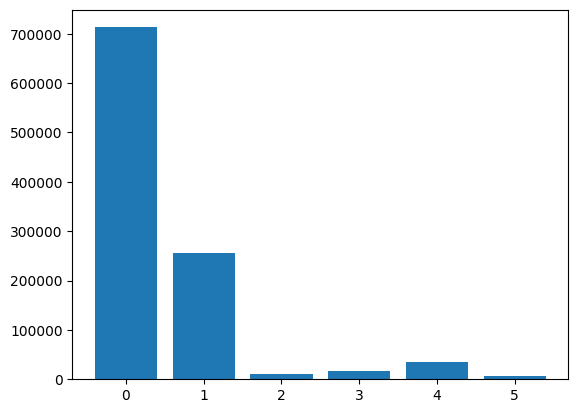

[713068 255919  10567  16917  34439   6497]
[0 1 2 3 4 5]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


total = []
for i in setup_train_real_node_label:
    total += i



labels, counts = np.unique(total, return_counts=True)

plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

print(counts)
print(labels)

## Setup 2

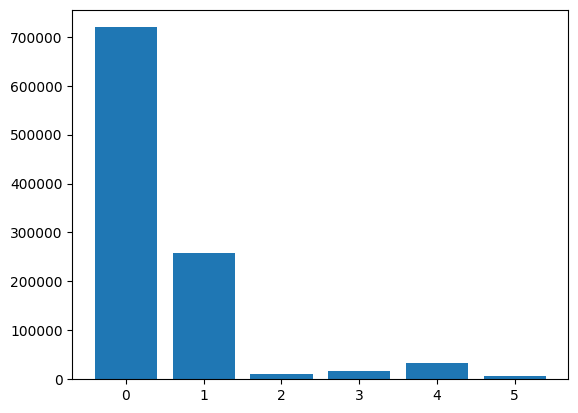

[719350 258068  11019  16795  34109   6877]


In [ ]:
total = []
for i in setup_train_real_node_label:
    total += i



labels, counts = np.unique(total, return_counts=True)

plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

print(counts)

## Setup 3

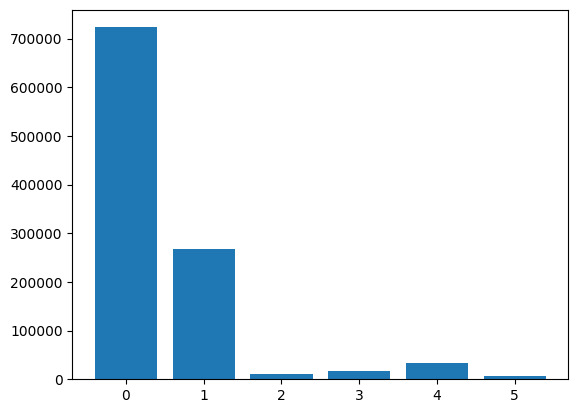

[723323 267110  11190  16974  33713   6836]


In [ ]:
total = []
for i in setup_train_real_node_label:
    total += i

import matplotlib.pyplot as plt

labels, counts = np.unique(total, return_counts=True)

plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

print(counts)

## Setup 4

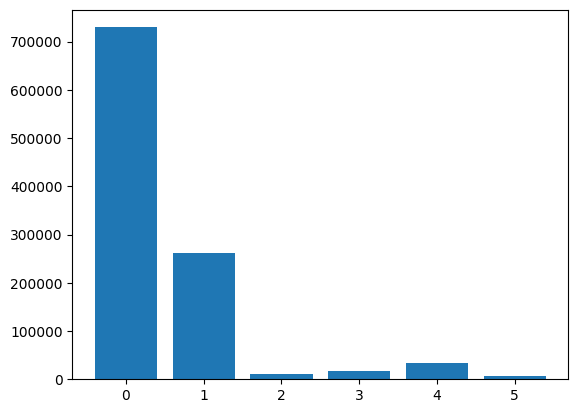

[729828 261339  10121  17104  34557   6801]


In [ ]:
total = []
for i in setup_train_real_node_label:
    total += i



labels, counts = np.unique(total, return_counts=True)

plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

print(counts)

## Setup 5

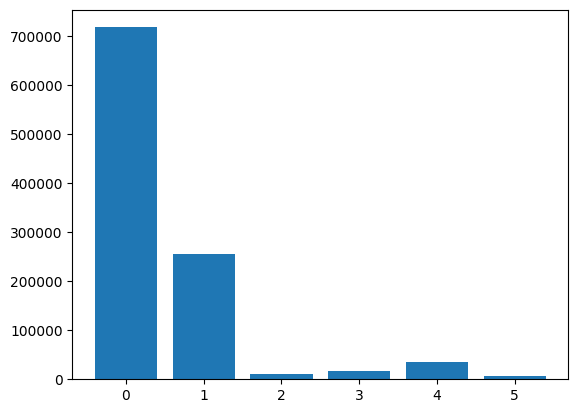

[718100 254782  11628  17029  34641   6319]


In [ ]:
total = []
for i in setup_train_real_node_label:
    total += i



labels, counts = np.unique(total, return_counts=True)

plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

print(counts)

## Compare with a base line with only class 0

In [ ]:
final_node_acc = sum(baseline_node_acc_list )/len(baseline_node_acc_list)
print("Node acc:", final_node_acc)
final_atom_acc = sum(baseline_atom_correct)/sum(test_atom_total)
print("Atom acc:", final_atom_acc)

Node acc: 0.6798658382983541
Atom acc: 0.6834740701923052


## Perform the McNemar test

In [ ]:
# Contingency table
#  Classifier2 Correct, Classifier2 Incorrect
# Classifier1 Correct Yes/Yes Yes/No
# Classifier1 Incorrect No/Yes No/No

baseline_node_acc_array = np.array(baseline_node_acc_list)
test_node_acc_array = np.array(test_node_acc_binary_list)

tmp = (baseline_node_acc_array == 1) & (test_node_acc_array == 1)
cell_11 = sum(tmp)

tmp2 = (baseline_node_acc_array == 1) & (test_node_acc_array == 0)
cell_12 = np.sum(tmp2)

tmp3 = (baseline_node_acc_array == 0) & (test_node_acc_array == 1)
cell_21 = np.sum(tmp3)

tmp4 = (baseline_node_acc_array == 0) & (test_node_acc_array == 0)
cell_22 = np.sum(tmp4)

print(cell_11, cell_12, cell_21, cell_22)

# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table
table = [[cell_11, cell_12],
 [cell_21, cell_22]]
# calculate mcnemar test, using syntax for > 25 per cell
result = mcnemar(table, exact=False, correction=True)
# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
 print('Same proportions of errors (fail to reject H0)')
else:
 print('Different proportions of errors (reject H0)')

230601 9599 31470 81635
statistic=11646.178, p-value=0.000
Different proportions of errors (reject H0)


## With tool box form course 02450

In [23]:
sys.path.append(os.path.abspath("/content/drive/MyDrive/02456 Deep learning/Model evaluation/"))

from toolbox_02450 import mcnemar

# Compute the Jeffreys interval
alpha = 0.05
[thetahat, CI, p] = mcnemar(np.ones_like(baseline_node_acc_array), baseline_node_acc_array, test_node_acc_array, alpha=alpha)

print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p)


Result of McNemars test using alpha= 0.05
Comparison matrix n
[[216920.  23280.]
 [ 48872.  64233.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.07390677432979686, -0.07096506475405862)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.0
theta = theta_A-theta_B point estimate -0.07243599722619266  CI:  (-0.07390677432979686, -0.07096506475405862) p-value 0.0


# Now evaluate the tree protein types based on the 5 models

## Model 1

In [16]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# put model to GPU
max_length = 30000
device = torch.device('cuda')
#device = torch.device('cpu')
model = SchNetModel(hidden_channels=128, out_dim=6, max_len=30000, max_num_neighbors=32).to(device)
criterion = nn.CrossEntropyLoss()
# Try with MSE loss
#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003,weight_decay=1e-4)


# Load state CV setup 1
check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup1_neighbors_Gauss_big_kernel_setup1.pth', map_location=torch.device('cuda'))

# Load state CV setup 2
#check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup2_Gauss_result.pth', map_location=torch.device('cuda'))

# Load state CV setup 3
#check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup3_Gauss_result.pth', map_location=torch.device('cuda'))

# Load state CV setup 4
#check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup4_Gauss_result.pth', map_location=torch.device('cuda'))

# Load state CV setup 5
#check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup5_Gauss_result.pth', map_location=torch.device('cuda'))


model.load_state_dict(check_point)
model.eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



SchNetModel(hidden_channels=128, num_filters=128, num_interactions=6, num_gaussians=50, cutoff=10)

In [17]:
_, _, _, _, _, _, _, \
  _, _, _, _, _, _, _,\
  setup1_test_data, setup1_test_label, setup1_test_batchname, setup1_test_dismatch_index_pred, setup1_test_dismatch_index_type, setup1_test_real_node_label, setup1_test_df = make_splits(cv0_lis, cv1_lis, cv2_lis, cv3_lis, cv4_lis, "setup 1")

In [18]:
from task import CreateDataLabel,MapAtomNode,node_accuracy
from scipy.ndimage import gaussian_filter1d

# data names
#  setup_test_data, setup_test_label, setup_test_batchname, setup_test_dismatch_index_pred, setup_test_dismatch_index_type, setup_test_real_node_label, setup_test_df
setup1_test_predict_node_label_lis = []
check_zero = []
test_node_acc_list = []
test_node_acc_binary_list = []

test_atom_acc_list = []
test_atom_correct = []
test_atom_total = []

baseline_atom_correct = []
baseline_atom_acc_list = []
baseline_node_acc_list = []
model.eval()
with torch.no_grad():

  for i, data in enumerate(setup1_test_data):
      torch.no_grad()
      outputs = model(data.to(device))
      prediction = outputs["node_embedding"]
      real_label = torch.argmax(torch.tensor(setup1_test_label[i]), dim=1).to(device)

      #prediction_Gauss = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3) )
      #prediction_Gauss = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3)).clone().detach().requires_grad_(True)

      smoothing = GaussianSmoothing(6, 29, 5, 1)
      predicted = torch.reshape(prediction.to('cpu'), (1,prediction.shape[1], prediction.shape[0]))
      predicted = F.pad(predicted, (14, 14), mode='reflect')
      predicted = smoothing(predicted)
      prediction_Gauss = torch.reshape(predicted, (prediction.shape[0], prediction.shape[1]))


      loss = criterion(prediction_Gauss.to(device), real_label)

      #_, predicted = torch.max(prediction, 1)

      _, predicted = torch.max(prediction_Gauss.to(device), 1)
      correct = (predicted == real_label).sum().item()
      total = real_label.size(0)
      atom_level_accuracy = correct / total

      test_atom_acc_list.append(atom_level_accuracy)
      test_atom_correct.append(correct)
      test_atom_total.append(total)

      # Baseline atom accuracy
      baseline_atom = torch.zeros_like(real_label) # note that in this case the most frequent class is class 0
      baseline_correct = (baseline_atom == real_label).sum().item()
      baseline_atom_correct.append(baseline_correct)



      processor = MapAtomNode(predicted.cpu(), setup1_test_batchname[i], setup1_test_dismatch_index_pred, setup1_test_dismatch_index_type, setup1_test_df)
      #print(processor.map_atom_node())
      test_predict_node_label = processor.map_atom_node()
      setup1_test_predict_node_label_lis.append(test_predict_node_label)
      accuracy_list = [1 if x == y else 0 for x, y in zip(test_predict_node_label, setup1_test_real_node_label[i])]
      test_node_acc_binary_list += accuracy_list
      node_level_accuracy = node_accuracy(test_predict_node_label, setup1_test_real_node_label[i])
      test_node_acc_list.append(node_level_accuracy)

      # Baseline node accuracy
      baseline_node_label = np.zeros_like(np.array(setup1_test_real_node_label[i])) # note that in this case the most frequent class is class 0
      baseline_accuracy = [1 if x == y else 0 for x, y in zip(baseline_node_label, setup1_test_real_node_label[i])]
      baseline_node_acc_list.append(baseline_accuracy)




#print("All real has 0:", sum(check_zero))
#print("node level acc:", node_level_accuracy)

In [21]:
print(len(setup1_test_predict_node_label_lis))
print(len(setup1_test_real_node_label))

final_node_acc = sum(test_node_acc_list)/len(test_node_acc_list)
print("Node acc:", final_node_acc)

final_node_binary_acc = sum(test_node_acc_binary_list)/len(test_node_acc_binary_list)
print("Node binary acc:", final_node_binary_acc)

final_atom_acc = sum(test_atom_acc_list)/len(test_atom_acc_list)
print("Avg atom acc:", final_atom_acc)

total_atom_acc = sum(test_atom_correct)/len(test_atom_total)
print("Total atom acc:", final_atom_acc)


test_resul = []
test_baseline = []
for i in range(0, len(setup1_test_predict_node_label_lis)):

  #for j in range(0, len(test_BETA_predict_node_label_lis[i])):
  topo_A = label_list_to_topology(setup1_test_predict_node_label_lis[i])
  topo_B = label_list_to_topology(setup1_test_real_node_label[i])
  topo_baseline = baseline_node_acc_list[i]

  test_resul.append(is_topologies_equal(topo_A, topo_B, 5))
  test_baseline.append(is_topologies_equal(topo_A, topo_baseline, 5))

print("Correct topology:", sum(test_resul)/len(test_resul))
print("Correct topology baseline:", sum(test_baseline)/len(test_baseline))


baseline_all = []
for i in range(0, len(baseline_node_acc_list)):
  baseline_all += baseline_node_acc_list[i]


final_node_acc = sum(baseline_all )/len(baseline_all)
print("Baseline Node acc:", final_node_acc)
final_atom_acc = sum(baseline_atom_correct)/sum(test_atom_total)
print("Baseline Atom acc:", final_atom_acc)



711
711
Node acc: 0.7140161872078112
Node binary acc: 0.7523018355245468
Avg atom acc: 0.704831385865173
Total atom acc: 0.704831385865173
Correct topology: 0.035161744022503515
Correct topology baseline: 0.0
Baseline Node acc: 0.6798658382983541
Baseline Atom acc: 0.6834740701923052


In [24]:
# Compute the Jeffreys interval
baseline_node_acc_array = np.array(baseline_all)
test_node_acc_array = np.array(test_node_acc_binary_list)

alpha = 0.05
[thetahat, CI, p] = mcnemar(np.ones_like(baseline_node_acc_array), baseline_node_acc_array, test_node_acc_array, alpha=alpha)

print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p)

Result of McNemars test using alpha= 0.05
Comparison matrix n
[[216920.  23280.]
 [ 48872.  64233.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.07390677432979686, -0.07096506475405862)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.0
theta = theta_A-theta_B point estimate -0.07243599722619266  CI:  (-0.07390677432979686, -0.07096506475405862) p-value 0.0


## Model 2

In [25]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# put model to GPU
max_length = 30000
device = torch.device('cuda')
#device = torch.device('cpu')
model = SchNetModel(hidden_channels=128, out_dim=6, max_len=30000, max_num_neighbors=32).to(device)
criterion = nn.CrossEntropyLoss()
# Try with MSE loss
#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003,weight_decay=1e-4)


# Load state CV setup 2
check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup2_Gauss_result.pth', map_location=torch.device('cuda'))

model.load_state_dict(check_point)
model.eval()



_, _, _, _, _, _, _, \
  _, _, _, _, _, _, _,\
  setup2_test_data, setup2_test_label, setup2_test_batchname, setup2_test_dismatch_index_pred, setup2_test_dismatch_index_type, setup2_test_real_node_label, setup2_test_df = make_splits(cv0_lis, cv1_lis, cv2_lis, cv3_lis, cv4_lis, "setup 2")




# data names
#  setup_test_data, setup_test_label, setup_test_batchname, setup_test_dismatch_index_pred, setup_test_dismatch_index_type, setup_test_real_node_label, setup_test_df
setup2_test_predict_node_label_lis = []
check_zero = []
test_node_acc_list = []
test_node_acc_binary_list = []

test_atom_acc_list = []
test_atom_correct = []
test_atom_total = []

baseline_atom_correct = []
baseline_atom_acc_list = []
baseline_node_acc_list = []
model.eval()
with torch.no_grad():

  for i, data in enumerate(setup2_test_data):
      torch.no_grad()
      outputs = model(data.to(device))
      prediction = outputs["node_embedding"]
      real_label = torch.argmax(torch.tensor(setup2_test_label[i]), dim=1).to(device)

      #prediction_Gauss = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3) )
      #prediction_Gauss = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3)).clone().detach().requires_grad_(True)

      smoothing = GaussianSmoothing(6, 29, 5, 1)
      predicted = torch.reshape(prediction.to('cpu'), (1,prediction.shape[1], prediction.shape[0]))
      predicted = F.pad(predicted, (14, 14), mode='reflect')
      predicted = smoothing(predicted)
      prediction_Gauss = torch.reshape(predicted, (prediction.shape[0], prediction.shape[1]))


      loss = criterion(prediction_Gauss.to(device), real_label)

      #_, predicted = torch.max(prediction, 1)

      _, predicted = torch.max(prediction_Gauss.to(device), 1)
      correct = (predicted == real_label).sum().item()
      total = real_label.size(0)
      atom_level_accuracy = correct / total

      test_atom_acc_list.append(atom_level_accuracy)
      test_atom_correct.append(correct)
      test_atom_total.append(total)

      # Baseline atom accuracy
      baseline_atom = torch.zeros_like(real_label) # note that in this case the most frequent class is class 0
      baseline_correct = (baseline_atom == real_label).sum().item()
      baseline_atom_correct.append(baseline_correct)



      processor = MapAtomNode(predicted.cpu(), setup2_test_batchname[i], setup2_test_dismatch_index_pred, setup2_test_dismatch_index_type, setup2_test_df)
      #print(processor.map_atom_node())
      test_predict_node_label = processor.map_atom_node()
      setup2_test_predict_node_label_lis.append(test_predict_node_label)
      accuracy_list = [1 if x == y else 0 for x, y in zip(test_predict_node_label, setup2_test_real_node_label[i])]
      test_node_acc_binary_list += accuracy_list
      node_level_accuracy = node_accuracy(test_predict_node_label, setup2_test_real_node_label[i])
      test_node_acc_list.append(node_level_accuracy)

      # Baseline node accuracy
      baseline_node_label = np.zeros_like(np.array(setup2_test_real_node_label[i])) # note that in this case the most frequent class is class 0
      baseline_accuracy = [1 if x == y else 0 for x, y in zip(baseline_node_label, setup2_test_real_node_label[i])]
      baseline_node_acc_list.append(baseline_accuracy)




#print("All real has 0:", sum(check_zero))
#print("node level acc:", node_level_accuracy)


print("For setup2: \n")

print(len(setup2_test_predict_node_label_lis))
print(len(setup2_test_real_node_label))

final_node_acc = sum(test_node_acc_list)/len(test_node_acc_list)
print("Node acc:", final_node_acc)

final_node_binary_acc = sum(test_node_acc_binary_list)/len(test_node_acc_binary_list)
print("Node binary acc:", final_node_binary_acc)

final_atom_acc = sum(test_atom_acc_list)/len(test_atom_acc_list)
print("Avg atom acc:", final_atom_acc)

total_atom_acc = sum(test_atom_correct)/len(test_atom_total)
print("Total atom acc:", final_atom_acc)


baseline_all = []
for i in range(0, len(baseline_node_acc_list)):
  baseline_all += baseline_node_acc_list[i]


final_node_acc = sum(baseline_all )/len(baseline_all)
print("Baseline Node acc:", final_node_acc)
final_atom_acc = sum(baseline_atom_correct)/sum(test_atom_total)
print("Baseline Atom acc:", final_atom_acc)


test_resul = []
test_baseline = []
for i in range(0, len(setup2_test_predict_node_label_lis)):

  #for j in range(0, len(test_BETA_predict_node_label_lis[i])):
  topo_A = label_list_to_topology(setup2_test_predict_node_label_lis[i])
  topo_B = label_list_to_topology(setup2_test_real_node_label[i])
  topo_baseline = baseline_node_acc_list[i]

  test_resul.append(is_topologies_equal(topo_A, topo_B, 5))
  test_baseline.append(is_topologies_equal(topo_A, topo_baseline, 5))

print("Correct topology:", sum(test_resul)/len(test_resul))
print("Correct topology baseline:", sum(test_baseline)/len(test_baseline))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



For setup2: 

713
713
Node acc: 0.7246587071429862
Node binary acc: 0.769271566466084
Avg atom acc: 0.7142647667670742
Total atom acc: 0.7142647667670742
Baseline Node acc: 0.6928360716364168
Baseline Atom acc: 0.6956950229883457
Correct topology: 0.015427769985974754
Correct topology baseline: 0.0


In [26]:
# Compute the Jeffreys interval
baseline_node_acc_array = np.array(baseline_all)
test_node_acc_array = np.array(test_node_acc_binary_list)

alpha = 0.05
[thetahat, CI, p] = mcnemar(np.ones_like(baseline_node_acc_array), baseline_node_acc_array, test_node_acc_array, alpha=alpha)

print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p)

Result of McNemars test using alpha= 0.05
Comparison matrix n
[[219419.  22254.]
 [ 48916.  58228.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.07791278309678984, -0.07495804106051385)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.0
theta = theta_A-theta_B point estimate -0.07643549482966713  CI:  (-0.07791278309678984, -0.07495804106051385) p-value 0.0


In [27]:
print('%.15f' % p)

0.000000000000000


## Model 3

In [28]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# put model to GPU
max_length = 30000
device = torch.device('cuda')
#device = torch.device('cpu')
model = SchNetModel(hidden_channels=128, out_dim=6, max_len=30000, max_num_neighbors=32).to(device)
criterion = nn.CrossEntropyLoss()
# Try with MSE loss
#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003,weight_decay=1e-4)


# Load state CV setup 3
check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup3_Gauss_result.pth', map_location=torch.device('cuda'))


model.load_state_dict(check_point)
model.eval()



_, _, _, _, _, _, _, \
  _, _, _, _, _, _, _,\
  setup3_test_data, setup3_test_label, setup3_test_batchname, setup3_test_dismatch_index_pred, setup3_test_dismatch_index_type, setup3_test_real_node_label, setup3_test_df = make_splits(cv0_lis, cv1_lis, cv2_lis, cv3_lis, cv4_lis, "setup 3")




# data names
#  setup_test_data, setup_test_label, setup_test_batchname, setup_test_dismatch_index_pred, setup_test_dismatch_index_type, setup_test_real_node_label, setup_test_df
setup3_test_predict_node_label_lis = []
check_zero = []
test_node_acc_list = []
test_node_acc_binary_list = []

test_atom_acc_list = []
test_atom_correct = []
test_atom_total = []

baseline_atom_correct = []
baseline_atom_acc_list = []
baseline_node_acc_list = []
model.eval()
with torch.no_grad():

  for i, data in enumerate(setup3_test_data):
      torch.no_grad()
      outputs = model(data.to(device))
      prediction = outputs["node_embedding"]
      real_label = torch.argmax(torch.tensor(setup3_test_label[i]), dim=1).to(device)

      #prediction_Gauss = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3) )
      #prediction_Gauss = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3)).clone().detach().requires_grad_(True)

      smoothing = GaussianSmoothing(6, 29, 5, 1)
      predicted = torch.reshape(prediction.to('cpu'), (1,prediction.shape[1], prediction.shape[0]))
      predicted = F.pad(predicted, (14, 14), mode='reflect')
      predicted = smoothing(predicted)
      prediction_Gauss = torch.reshape(predicted, (prediction.shape[0], prediction.shape[1]))


      loss = criterion(prediction_Gauss.to(device), real_label)

     # _, predicted = torch.max(prediction, 1)

      _, predicted = torch.max(prediction_Gauss.to(device), 1)
      correct = (predicted == real_label).sum().item()
      total = real_label.size(0)
      atom_level_accuracy = correct / total

      test_atom_acc_list.append(atom_level_accuracy)
      test_atom_correct.append(correct)
      test_atom_total.append(total)

      # Baseline atom accuracy
      baseline_atom = torch.zeros_like(real_label) # note that in this case the most frequent class is class 0
      baseline_correct = (baseline_atom == real_label).sum().item()
      baseline_atom_correct.append(baseline_correct)



      processor = MapAtomNode(predicted.cpu(), setup3_test_batchname[i], setup3_test_dismatch_index_pred, setup3_test_dismatch_index_type, setup3_test_df)
      #print(processor.map_atom_node())
      test_predict_node_label = processor.map_atom_node()
      setup3_test_predict_node_label_lis.append(test_predict_node_label)
      accuracy_list = [1 if x == y else 0 for x, y in zip(test_predict_node_label, setup3_test_real_node_label[i])]
      test_node_acc_binary_list += accuracy_list
      node_level_accuracy = node_accuracy(test_predict_node_label, setup3_test_real_node_label[i])
      test_node_acc_list.append(node_level_accuracy)

      # Baseline node accuracy
      baseline_node_label = np.zeros_like(np.array(setup3_test_real_node_label[i])) # note that in this case the most frequent class is class 0
      baseline_accuracy = [1 if x == y else 0 for x, y in zip(baseline_node_label, setup3_test_real_node_label[i])]
      baseline_node_acc_list.append(baseline_accuracy)




#print("All real has 0:", sum(check_zero))
#print("node level acc:", node_level_accuracy)


print("For setup3: \n")

print(len(setup3_test_predict_node_label_lis))
print(len(setup3_test_real_node_label))

final_node_acc = sum(test_node_acc_list)/len(test_node_acc_list)
print("Node acc:", final_node_acc)

final_node_binary_acc = sum(test_node_acc_binary_list)/len(test_node_acc_binary_list)
print("Node binary acc:", final_node_binary_acc)

final_atom_acc = sum(test_atom_acc_list)/len(test_atom_acc_list)
print("Avg atom acc:", final_atom_acc)

total_atom_acc = sum(test_atom_correct)/len(test_atom_total)
print("Total atom acc:", final_atom_acc)


baseline_all = []
for i in range(0, len(baseline_node_acc_list)):
  baseline_all += baseline_node_acc_list[i]


final_node_acc = sum(baseline_all )/len(baseline_all)
print("Baseline Node acc:", final_node_acc)
final_atom_acc = sum(baseline_atom_correct)/sum(test_atom_total)
print("Baseline Atom acc:", final_atom_acc)



test_resul = []
test_baseline = []
for i in range(0, len(setup3_test_predict_node_label_lis)):

  #for j in range(0, len(test_BETA_predict_node_label_lis[i])):
  topo_A = label_list_to_topology(setup3_test_predict_node_label_lis[i])
  topo_B = label_list_to_topology(setup3_test_real_node_label[i])
  topo_baseline = baseline_node_acc_list[i]

  test_resul.append(is_topologies_equal(topo_A, topo_B, 5))
  test_baseline.append(is_topologies_equal(topo_A, topo_baseline, 5))

print("Correct topology:", sum(test_resul)/len(test_resul))
print("Correct topology baseline:", sum(test_baseline)/len(test_baseline))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



For setup3: 

710
710
Node acc: 0.7128902741293843
Node binary acc: 0.7546250187292326
Avg atom acc: 0.7030090071024008
Total atom acc: 0.7030090071024008
Baseline Node acc: 0.6940157531208043
Baseline Atom acc: 0.6968651481538033
Correct topology: 0.02535211267605634
Correct topology baseline: 0.0


In [29]:
# Compute the Jeffreys interval
baseline_node_acc_array = np.array(baseline_all)
test_node_acc_array = np.array(test_node_acc_binary_list)

alpha = 0.05
[thetahat, CI, p] = mcnemar(np.ones_like(baseline_node_acc_array), baseline_node_acc_array, test_node_acc_array, alpha=alpha)

print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p)
print('%.15f' % p)

Result of McNemars test using alpha= 0.05
Comparison matrix n
[[216003.  20224.]
 [ 40854.  63296.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.06201764529473208, -0.05920076690823173)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.0
theta = theta_A-theta_B point estimate -0.0606092656084283  CI:  (-0.06201764529473208, -0.05920076690823173) p-value 0.0
0.000000000000000


## Model 4

In [30]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# put model to GPU
max_length = 30000
device = torch.device('cuda')
#device = torch.device('cpu')
model = SchNetModel(hidden_channels=128, out_dim=6, max_len=30000, max_num_neighbors=32).to(device)
criterion = nn.CrossEntropyLoss()
# Try with MSE loss
#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003,weight_decay=1e-4)


# Load state CV setup 4
check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup4_Gauss_result.pth', map_location=torch.device('cuda'))


model.load_state_dict(check_point)
model.eval()



_, _, _, _, _, _, _, \
  _, _, _, _, _, _, _,\
  setup4_test_data, setup4_test_label, setup4_test_batchname, setup4_test_dismatch_index_pred, setup4_test_dismatch_index_type, setup4_test_real_node_label, setup4_test_df = make_splits(cv0_lis, cv1_lis, cv2_lis, cv3_lis, cv4_lis, "setup 4")




# data names
#  setup_test_data, setup_test_label, setup_test_batchname, setup_test_dismatch_index_pred, setup_test_dismatch_index_type, setup_test_real_node_label, setup_test_df
setup4_test_predict_node_label_lis = []
check_zero = []
test_node_acc_list = []
test_node_acc_binary_list = []

test_atom_acc_list = []
test_atom_correct = []
test_atom_total = []

baseline_atom_correct = []
baseline_atom_acc_list = []
baseline_node_acc_list = []
model.eval()
with torch.no_grad():

  for i, data in enumerate(setup4_test_data):
      torch.no_grad()
      outputs = model(data.to(device))
      prediction = outputs["node_embedding"]
      real_label = torch.argmax(torch.tensor(setup4_test_label[i]), dim=1).to(device)

      #prediction_Gauss = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3) )
      #prediction_Gauss = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3)).clone().detach().requires_grad_(True)

      smoothing = GaussianSmoothing(6, 29, 5, 1)
      predicted = torch.reshape(prediction.to('cpu'), (1,prediction.shape[1], prediction.shape[0]))
      predicted = F.pad(predicted, (14, 14), mode='reflect')
      predicted = smoothing(predicted)
      prediction_Gauss = torch.reshape(predicted, (prediction.shape[0], prediction.shape[1]))


      loss = criterion(prediction_Gauss.to(device), real_label)

      #_, predicted = torch.max(prediction, 1)

      _, predicted = torch.max(prediction_Gauss.to(device), 1)
      correct = (predicted == real_label).sum().item()
      total = real_label.size(0)
      atom_level_accuracy = correct / total

      test_atom_acc_list.append(atom_level_accuracy)
      test_atom_correct.append(correct)
      test_atom_total.append(total)

      # Baseline atom accuracy
      baseline_atom = torch.zeros_like(real_label) # note that in this case the most frequent class is class 0
      baseline_correct = (baseline_atom == real_label).sum().item()
      baseline_atom_correct.append(baseline_correct)



      processor = MapAtomNode(predicted.cpu(), setup4_test_batchname[i], setup4_test_dismatch_index_pred, setup4_test_dismatch_index_type, setup4_test_df)
      #print(processor.map_atom_node())
      test_predict_node_label = processor.map_atom_node()
      setup4_test_predict_node_label_lis.append(test_predict_node_label)
      accuracy_list = [1 if x == y else 0 for x, y in zip(test_predict_node_label, setup4_test_real_node_label[i])]
      test_node_acc_binary_list += accuracy_list
      node_level_accuracy = node_accuracy(test_predict_node_label, setup4_test_real_node_label[i])
      test_node_acc_list.append(node_level_accuracy)

      # Baseline node accuracy
      baseline_node_label = np.zeros_like(np.array(setup4_test_real_node_label[i])) # note that in this case the most frequent class is class 0
      baseline_accuracy = [1 if x == y else 0 for x, y in zip(baseline_node_label, setup4_test_real_node_label[i])]
      baseline_node_acc_list.append(baseline_accuracy)




#print("All real has 0:", sum(check_zero))
#print("node level acc:", node_level_accuracy)


print("For setup4: \n")

print(len(setup4_test_predict_node_label_lis))
print(len(setup4_test_real_node_label))

final_node_acc = sum(test_node_acc_list)/len(test_node_acc_list)
print("Node acc:", final_node_acc)

final_node_binary_acc = sum(test_node_acc_binary_list)/len(test_node_acc_binary_list)
print("Node binary acc:", final_node_binary_acc)

final_atom_acc = sum(test_atom_acc_list)/len(test_atom_acc_list)
print("Avg atom acc:", final_atom_acc)

total_atom_acc = sum(test_atom_correct)/len(test_atom_total)
print("Total atom acc:", final_atom_acc)


baseline_all = []
for i in range(0, len(baseline_node_acc_list)):
  baseline_all += baseline_node_acc_list[i]


final_node_acc = sum(baseline_all )/len(baseline_all)
print("Baseline Node acc:", final_node_acc)
final_atom_acc = sum(baseline_atom_correct)/sum(test_atom_total)
print("Baseline Atom acc:", final_atom_acc)



test_resul = []
test_baseline = []
for i in range(0, len(setup4_test_predict_node_label_lis)):

  #for j in range(0, len(test_BETA_predict_node_label_lis[i])):
  topo_A = label_list_to_topology(setup4_test_predict_node_label_lis[i])
  topo_B = label_list_to_topology(setup4_test_real_node_label[i])
  topo_baseline = baseline_node_acc_list[i]

  test_resul.append(is_topologies_equal(topo_A, topo_B, 5))
  test_baseline.append(is_topologies_equal(topo_A, topo_baseline, 5))

print("Correct topology:", sum(test_resul)/len(test_resul))
print("Correct topology baseline:", sum(test_baseline)/len(test_baseline))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



For setup4: 

704
704
Node acc: 0.7278993292375238
Node binary acc: 0.7625648669061752
Avg atom acc: 0.718430276855235
Total atom acc: 0.718430276855235
Baseline Node acc: 0.6753567500351796
Baseline Atom acc: 0.6781655817364995
Correct topology: 0.028409090909090908
Correct topology baseline: 0.0


In [31]:
# Compute the Jeffreys interval
baseline_node_acc_array = np.array(baseline_all)
test_node_acc_array = np.array(test_node_acc_binary_list)

alpha = 0.05
[thetahat, CI, p] = mcnemar(np.ones_like(baseline_node_acc_array), baseline_node_acc_array, test_node_acc_array, alpha=alpha)

print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p)
print('%.15f' % p)

Result of McNemars test using alpha= 0.05
Comparison matrix n
[[212902.  22266.]
 [ 52633.  60412.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.08872096433018328, -0.08569507102902008)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.0
theta = theta_A-theta_B point estimate -0.08720811687099563  CI:  (-0.08872096433018328, -0.08569507102902008) p-value 0.0
0.000000000000000


## Model 5

In [32]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# put model to GPU
max_length = 30000
device = torch.device('cuda')
#device = torch.device('cpu')
model = SchNetModel(hidden_channels=128, out_dim=6, max_len=30000, max_num_neighbors=32).to(device)
criterion = nn.CrossEntropyLoss()
# Try with MSE loss
#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003,weight_decay=1e-4)


# Load state CV setup 5
check_point = torch.load('/content/drive/MyDrive/02456 Deep learning/Model evaluation/schnet_majorvoting/models/CV_setup5_Gauss_result.pth', map_location=torch.device('cuda'))


model.load_state_dict(check_point)
model.eval()


_, _, _, _, _, _, _, \
  _, _, _, _, _, _, _,\
  setup5_test_data, setup5_test_label, setup5_test_batchname, setup5_test_dismatch_index_pred, setup5_test_dismatch_index_type, setup5_test_real_node_label, setup5_test_df = make_splits(cv0_lis, cv1_lis, cv2_lis, cv3_lis, cv4_lis, "setup 5")




# data names
#  setup_test_data, setup_test_label, setup_test_batchname, setup_test_dismatch_index_pred, setup_test_dismatch_index_type, setup_test_real_node_label, setup_test_df
setup5_test_predict_node_label_lis = []
check_zero = []
test_node_acc_list = []
test_node_acc_binary_list = []

test_atom_acc_list = []
test_atom_correct = []
test_atom_total = []

baseline_atom_correct = []
baseline_atom_acc_list = []
baseline_node_acc_list = []
model.eval()
with torch.no_grad():

  for i, data in enumerate(setup5_test_data):
      torch.no_grad()
      outputs = model(data.to(device))
      prediction = outputs["node_embedding"]
      real_label = torch.argmax(torch.tensor(setup5_test_label[i]), dim=1).to(device)

      #prediction_Gauss = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3) )
      #prediction_Gauss = torch.from_numpy(gaussian_filter1d(prediction.cpu().detach().numpy(), 1, radius=3)).clone().detach().requires_grad_(True)

      smoothing = GaussianSmoothing(6, 29, 5, 1)
      predicted = torch.reshape(prediction.to('cpu'), (1,prediction.shape[1], prediction.shape[0]))
      predicted = F.pad(predicted, (14, 14), mode='reflect')
      predicted = smoothing(predicted)
      prediction_Gauss = torch.reshape(predicted, (prediction.shape[0], prediction.shape[1]))


      loss = criterion(prediction_Gauss.to(device), real_label)

      #_, predicted = torch.max(prediction, 1)

      _, predicted = torch.max(prediction_Gauss.to(device), 1)
      correct = (predicted == real_label).sum().item()
      total = real_label.size(0)
      atom_level_accuracy = correct / total

      test_atom_acc_list.append(atom_level_accuracy)
      test_atom_correct.append(correct)
      test_atom_total.append(total)

      # Baseline atom accuracy
      baseline_atom = torch.zeros_like(real_label) # note that in this case the most frequent class is class 0
      baseline_correct = (baseline_atom == real_label).sum().item()
      baseline_atom_correct.append(baseline_correct)



      processor = MapAtomNode(predicted.cpu(), setup5_test_batchname[i], setup5_test_dismatch_index_pred, setup5_test_dismatch_index_type, setup5_test_df)
      #print(processor.map_atom_node())
      test_predict_node_label = processor.map_atom_node()
      setup5_test_predict_node_label_lis.append(test_predict_node_label)
      accuracy_list = [1 if x == y else 0 for x, y in zip(test_predict_node_label, setup5_test_real_node_label[i])]
      test_node_acc_binary_list += accuracy_list
      node_level_accuracy = node_accuracy(test_predict_node_label, setup5_test_real_node_label[i])
      test_node_acc_list.append(node_level_accuracy)

      # Baseline node accuracy
      baseline_node_label = np.zeros_like(np.array(setup5_test_real_node_label[i])) # note that in this case the most frequent class is class 0
      baseline_accuracy = [1 if x == y else 0 for x, y in zip(baseline_node_label, setup5_test_real_node_label[i])]
      baseline_node_acc_list.append(baseline_accuracy)




#print("All real has 0:", sum(check_zero))
#print("node level acc:", node_level_accuracy)


print("For setup5: \n")

print(len(setup5_test_predict_node_label_lis))
print(len(setup5_test_real_node_label))

final_node_acc = sum(test_node_acc_list)/len(test_node_acc_list)
print("Node acc:", final_node_acc)

final_node_binary_acc = sum(test_node_acc_binary_list)/len(test_node_acc_binary_list)
print("Node binary acc:", final_node_binary_acc)

final_atom_acc = sum(test_atom_acc_list)/len(test_atom_acc_list)
print("Avg atom acc:", final_atom_acc)

total_atom_acc = sum(test_atom_correct)/len(test_atom_total)
print("Total atom acc:", final_atom_acc)


baseline_all = []
for i in range(0, len(baseline_node_acc_list)):
  baseline_all += baseline_node_acc_list[i]


final_node_acc = sum(baseline_all )/len(baseline_all)
print("Baseline Node acc:", final_node_acc)
final_atom_acc = sum(baseline_atom_correct)/sum(test_atom_total)
print("Baseline Atom acc:", final_atom_acc)




test_resul = []
test_baseline = []
for i in range(0, len(setup5_test_predict_node_label_lis)):

  #for j in range(0, len(test_BETA_predict_node_label_lis[i])):
  topo_A = label_list_to_topology(setup5_test_predict_node_label_lis[i])
  topo_B = label_list_to_topology(setup5_test_real_node_label[i])
  topo_baseline = baseline_node_acc_list[i]

  test_resul.append(is_topologies_equal(topo_A, topo_B, 5))
  test_baseline.append(is_topologies_equal(topo_A, topo_baseline, 5))

print("Correct topology:", sum(test_resul)/len(test_resul))
print("Correct topology baseline:", sum(test_baseline)/len(test_baseline))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



For setup5: 

704
704
Node acc: 0.7052251753126465
Node binary acc: 0.7555951994810249
Avg atom acc: 0.6974998797869216
Total atom acc: 0.6974998797869216
Baseline Node acc: 0.6933321775699889
Baseline Atom acc: 0.6953767072007256
Correct topology: 0.048295454545454544
Correct topology baseline: 0.0


In [33]:
# Compute the Jeffreys interval
baseline_node_acc_array = np.array(baseline_all)
test_node_acc_array = np.array(test_node_acc_binary_list)

alpha = 0.05
[thetahat, CI, p] = mcnemar(np.ones_like(baseline_node_acc_array), baseline_node_acc_array, test_node_acc_array, alpha=alpha)

print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p)
print('%.15f' % p)

Result of McNemars test using alpha= 0.05
Comparison matrix n
[[238383.   9572.]
 [ 31839.  77834.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.06335941100255793, -0.06116655871241461)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.0
theta = theta_A-theta_B point estimate -0.06226302191103605  CI:  (-0.06335941100255793, -0.06116655871241461) p-value 0.0
0.000000000000000


## Now gather for the five types

In [36]:
# The data

#train_data,train_lable, train_batchname, train_max_len,train_dismatch_index_pred,train_dismatch_index_type,train_real_node_label,df_train = processor.datalabelgenerator('train')

#val_data,val_lable, val_batchname, val_max_len,val_dismatch_index_pred,val_dismatch_index_type,val_real_node_label,df_val = processor.datalabelgenerator('val')

#test_SP_TM_data,test_SP_TM_lable, test_SP_TM_batchname, test_SP_TM_max_len,test_SP_TM_dismatch_index_pred,test_SP_TM_dismatch_index_type,test_SP_TM_real_node_label,df_test_SP_TM = processor.datalabelgenerator('test_SP_TM')

#test_TM_data,test_TM_lable, test_TM_batchname, test_TM_max_len,test_TM_dismatch_index_pred,test_TM_dismatch_index_type,test_TM_real_node_label,df_test_TM = processor.datalabelgenerator('test_TM')

#test_BETA_data,test_BETA_lable, test_BETA_batchname, test_BETA_max_len,test_BETA_dismatch_index_pred,test_BETA_dismatch_index_type,test_BETA_real_node_label,df_test_BETA = processor.datalabelgenerator('test_BETA')



#setup1_test_data, setup1_test_label, setup1_test_batchname, setup1_test_dismatch_index_pred, setup1_test_dismatch_index_type, setup1_test_real_node_label, setup1_test_df
test_data = setup1_test_data.copy()
test_label = setup1_test_label.copy()
test_batchname = setup1_test_batchname.copy()
#test_max_len = train_max_len + val_max_len + test_SP_TM_max_len + test_TM_max_len + test_BETA_max_len
test_dismatch_index_pred = setup1_test_dismatch_index_pred.copy()
test_dismatch_index_type = setup1_test_dismatch_index_type.copy()
test_real_node_label = setup1_test_real_node_label.copy()

test_frames = [setup1_test_df, setup2_test_df, setup3_test_df, setup4_test_df, setup5_test_df]
total_df = pd.concat(test_frames)
all_test_predict_node_label = setup1_test_predict_node_label_lis.copy()

#setup5_test_predict_node_label_lis
#all_test_predict_node_label = setup1_test_predict_node_label_lis + setup2_test_predict_node_label_lis + setup3_test_predict_node_label_lis + setup4_test_predict_node_label_lis + setup5_test_predict_node_label_lis


for i in range(0, len(setup2_test_data)):
  test_data.append(setup2_test_data[i])
  test_label.append(setup2_test_label[i])
  test_batchname.append(setup2_test_batchname[i])
  test_dismatch_index_pred[list(setup2_test_dismatch_index_pred)[i]] = list(setup2_test_dismatch_index_pred.values())[i]
  test_dismatch_index_type[list(setup2_test_dismatch_index_type)[i]] = list(setup2_test_dismatch_index_type.values())[i]
  test_real_node_label.append(setup2_test_real_node_label[i])
  all_test_predict_node_label.append(setup2_test_predict_node_label_lis[i])


for i in range(0, len(setup3_test_data)):
  test_data.append(setup3_test_data[i])
  test_label.append(setup3_test_label[i])
  test_batchname.append(setup3_test_batchname[i])
  test_dismatch_index_pred[list(setup3_test_dismatch_index_pred)[i]] = list(setup3_test_dismatch_index_pred.values())[i]
  test_dismatch_index_type[list(setup3_test_dismatch_index_type)[i]] = list(setup3_test_dismatch_index_type.values())[i]
  test_real_node_label.append(setup3_test_real_node_label[i])
  all_test_predict_node_label.append(setup3_test_predict_node_label_lis[i])


for i in range(0, len(setup4_test_data)):
  test_data.append(setup4_test_data[i])
  test_label.append(setup4_test_label[i])
  test_batchname.append(setup4_test_batchname[i])
  test_dismatch_index_pred[list(setup4_test_dismatch_index_pred)[i]] = list(setup4_test_dismatch_index_pred.values())[i]
  test_dismatch_index_type[list(setup4_test_dismatch_index_type)[i]] = list(setup4_test_dismatch_index_type.values())[i]
  test_real_node_label.append(setup4_test_real_node_label[i])
  all_test_predict_node_label.append(setup4_test_predict_node_label_lis[i])


for i in range(0, len(setup5_test_data)):
  test_data.append(setup5_test_data[i])
  test_label.append(setup5_test_label[i])
  test_batchname.append(setup5_test_batchname[i])
  test_dismatch_index_pred[list(setup5_test_dismatch_index_pred)[i]] = list(setup5_test_dismatch_index_pred.values())[i]
  test_dismatch_index_type[list(setup5_test_dismatch_index_type)[i]] = list(setup5_test_dismatch_index_type.values())[i]
  test_real_node_label.append(setup5_test_real_node_label[i])
  all_test_predict_node_label.append(setup5_test_predict_node_label_lis[i])





### SP + TM

In [39]:
#test_SP_TM_data,test_SP_TM_lable, test_SP_TM_batchname, test_SP_TM_max_len,test_SP_TM_dismatch_index_pred,test_SP_TM_dismatch_index_type,test_SP_TM_real_node_label,df_test_SP_TM = processor.datalabelgenerator('test_SP_TM')


final_test_SP_TM_pred_label = []
final_test_SP_TM_real_label = []
for i in range(0, len(test_SP_TM_batchname)):
  idx = test_batchname.index(test_SP_TM_batchname[i])
  #print(idx)

  final_test_SP_TM_pred_label.append(all_test_predict_node_label[idx])
  final_test_SP_TM_real_label.append(test_real_node_label[idx])


SP_TM_test_resul = []
SP_TM_node_acc = []
SP_TM_avg_acc = []
baseline_avg_acc = []
for i in range(0, len(final_test_SP_TM_pred_label)):
  #smoothened = gaussian_filter1d(final_test_SP_TM_pred_label[i], 4, radius=28)  # using same Gaussian filter setup as TMBED article
  topo_A = label_list_to_topology(final_test_SP_TM_pred_label[i])
  topo_B = label_list_to_topology(final_test_SP_TM_real_label[i])

  SP_TM_test_resul.append(is_topologies_equal(topo_A, topo_B, 5))
  SP_TM_node_acc += (np.array(final_test_SP_TM_pred_label[i]) == np.array(final_test_SP_TM_real_label[i])).tolist()
  acc_lis = (np.array(final_test_SP_TM_pred_label[i]) == np.array(final_test_SP_TM_real_label[i])).tolist()
  SP_TM_avg_acc.append(sum(acc_lis)/len(acc_lis))

  acc_baseline_lis = (np.array(np.zeros_like(final_test_SP_TM_pred_label[i])) == np.array(final_test_SP_TM_real_label[i])).tolist()
  baseline_avg_acc.append(sum(acc_baseline_lis)/len(acc_baseline_lis))


resul = sum(SP_TM_test_resul)/len(SP_TM_test_resul)

print("Correct topology for SP + TM:")
print('%.15f' % resul)


print("Node acc for SP + TM:", sum(SP_TM_node_acc)/len(SP_TM_node_acc) )
print("Node avg. acc for SP + TM:", sum(SP_TM_avg_acc)/len(SP_TM_avg_acc) )
print("Node avg. acc for SP + TM baseline:", sum(baseline_avg_acc)/len(baseline_avg_acc) )

Correct topology for SP + TM:
0.000000000000000
Node acc for SP + TM: 0.5354552968513638
Node avg. acc for SP + TM: 0.5080807969632734
Node avg. acc for SP + TM baseline: 0.17251701645533116


### TM

In [40]:
final_test_TM_pred_label = []
final_test_TM_real_label = []
for i in range(0, len(test_TM_batchname)):
  idx = test_batchname.index(test_TM_batchname[i])

  final_test_TM_pred_label.append(all_test_predict_node_label[idx])
  final_test_TM_real_label.append(test_real_node_label[idx])


TM_test_resul = []
TM_node_acc = []
TM_avg_acc = []
baseline_avg_acc = []
for i in range(0, len(final_test_TM_pred_label)):
  #smoothened = gaussian_filter1d(final_test_TM_pred_label[i], 3, radius=10)  # using same Gaussian filter setup as TMBED article
  topo_A = label_list_to_topology(final_test_TM_pred_label[i])
  topo_B = label_list_to_topology(final_test_TM_real_label[i])

  TM_test_resul.append(is_topologies_equal(topo_A, topo_B, 5))
  TM_node_acc += (np.array(final_test_TM_pred_label[i]) == np.array(final_test_TM_real_label[i])).tolist()
  acc_lis = (np.array(final_test_TM_pred_label[i]) == np.array(final_test_TM_real_label[i])).tolist()
  TM_avg_acc.append(sum(acc_lis)/len(acc_lis))

  acc_baseline_lis = (np.array(np.zeros_like(final_test_TM_pred_label[i])) == np.array(final_test_TM_real_label[i])).tolist()
  baseline_avg_acc.append(sum(acc_baseline_lis)/len(acc_baseline_lis))

resul = sum(TM_test_resul)/len(TM_test_resul)

print("Correct topology for TM:")
print('%.15f' % resul)

print("Node acc for TM:", sum(TM_node_acc)/len(TM_node_acc) )
print("Node avg. acc for TM:", sum(TM_avg_acc)/len(TM_avg_acc) )
print("Node avg. acc for TM baseline:", sum(baseline_avg_acc)/len(baseline_avg_acc) )

Correct topology for TM:
0.000000000000000
Node acc for TM: 0.6134703921257343
Node avg. acc for TM: 0.5949777255853409
Node avg. acc for TM baseline: 0.39751710338075336


### Beta

In [41]:
final_test_BETA_pred_label = []
final_test_BETA_real_label = []
for i in range(0, len(test_BETA_batchname)):
  idx = test_batchname.index(test_BETA_batchname[i])

  final_test_BETA_pred_label.append(all_test_predict_node_label[idx])
  final_test_BETA_real_label.append(test_real_node_label[idx])


BETA_test_resul = []
BETA_node_acc = []
BETA_avg_acc = []
baseline_avg_acc = []
for i in range(0, len(final_test_BETA_pred_label)):

  topo_A = label_list_to_topology(final_test_BETA_pred_label[i])
  topo_B = label_list_to_topology(final_test_BETA_real_label[i])

  BETA_test_resul.append(is_topologies_equal(topo_A, topo_B, 2))

  BETA_node_acc += (np.array(final_test_BETA_pred_label[i]) == np.array(final_test_BETA_real_label[i])).tolist()
  acc_lis = (np.array(final_test_BETA_pred_label[i]) == np.array(final_test_BETA_real_label[i])).tolist()
  BETA_avg_acc.append(sum(acc_lis)/len(acc_lis))

  acc_baseline_lis = (np.array(np.zeros_like(final_test_BETA_pred_label[i])) == np.array(final_test_BETA_real_label[i])).tolist()
  baseline_avg_acc.append(sum(acc_baseline_lis)/len(acc_baseline_lis))

print("Correct topology for BETA:", sum(BETA_test_resul)/len(BETA_test_resul))

print("Node acc for BETA:", sum(BETA_node_acc)/len(BETA_node_acc) )

print("Node avg. acc for BETA:", sum(BETA_avg_acc)/len(BETA_avg_acc) )
print("Node avg. acc for BETA baseline:", sum(baseline_avg_acc)/len(baseline_avg_acc) )

Correct topology for BETA: 0.0
Node acc for BETA: 0.2463460894789691
Node avg. acc for BETA: 0.2644113406673705
Node avg. acc for BETA baseline: 0.0


## Globular and Globular SP

In [43]:
final_test_glob_pred_label_1 = []
final_test_glob_real_label_1 = []
for i in range(0, len(train_batchname)):
  idx = test_batchname.index(train_batchname[i])

  final_test_glob_pred_label_1.append(all_test_predict_node_label[idx])
  final_test_glob_real_label_1.append(test_real_node_label[idx])


final_test_glob_pred_label_2 = []
final_test_glob_real_label_2 = []
for i in range(0, len(val_batchname)):
  idx = test_batchname.index(val_batchname[i])

  final_test_glob_pred_label_2.append(all_test_predict_node_label[idx])
  final_test_glob_real_label_2.append(test_real_node_label[idx])



glob_test_resul = []
glob_node_acc = []
glob_avg_acc = []
baseline_avg_acc = []
for i in range(0, len(final_test_glob_pred_label_1)):

  topo_A = label_list_to_topology(final_test_glob_pred_label_1[i])
  topo_B = label_list_to_topology(final_test_glob_real_label_1[i])

  glob_test_resul.append(is_topologies_equal(topo_A, topo_B, 5))

  glob_node_acc += (np.array(final_test_glob_pred_label_1[i]) == np.array(final_test_glob_real_label_1[i])).tolist()
  acc_lis = (np.array(final_test_glob_pred_label_1[i]) == np.array(final_test_glob_real_label_1[i])).tolist()
  glob_avg_acc.append(sum(acc_lis)/len(acc_lis))

  acc_baseline_lis = (np.array(np.zeros_like(final_test_glob_pred_label_1[i])) == np.array(final_test_glob_real_label_1[i])).tolist()
  baseline_avg_acc.append(sum(acc_baseline_lis)/len(acc_baseline_lis))



for i in range(0, len(final_test_glob_pred_label_2)):

  topo_A = label_list_to_topology(final_test_glob_pred_label_2[i])
  topo_B = label_list_to_topology(final_test_glob_real_label_2[i])

  glob_test_resul.append(is_topologies_equal(topo_A, topo_B, 5))

  glob_node_acc += (np.array(final_test_glob_pred_label_2[i]) == np.array(final_test_glob_real_label_2[i])).tolist()
  acc_lis = (np.array(final_test_glob_pred_label_2[i]) == np.array(final_test_glob_real_label_2[i])).tolist()
  glob_avg_acc.append(sum(acc_lis)/len(acc_lis))

  acc_baseline_lis = (np.array(np.zeros_like(final_test_glob_pred_label_2[i])) == np.array(final_test_glob_real_label_2[i])).tolist()
  baseline_avg_acc.append(sum(acc_baseline_lis)/len(acc_baseline_lis))




print("Correct topology for glob:", sum(glob_test_resul)/len(glob_test_resul))

print("Node acc for glob:", sum(glob_node_acc)/len(glob_node_acc) )

print("Node avg. acc for glob:", sum(glob_avg_acc)/len(glob_avg_acc) )
print("Node avg. acc for glob baseline:", sum(baseline_avg_acc)/len(baseline_avg_acc) )

Correct topology for glob: 0.03627813234800134
Node acc for glob: 0.8018748761132718
Node avg. acc for glob: 0.7520644481273024
Node avg. acc for glob baseline: 0.6661068189452469


# Try define larger batch size

In [ ]:
test_BETA_data,test_BETA_lable, test_BETA_batchname, test_BETA_max_len,test_BETA_dismatch_index_pred,test_BETA_dismatch_index_type,test_BETA_real_node_label,df_test_BETA = processor.datalabelgenerator('test_BETA')
test = test_BETA_data.copy()
len(test)


[12/17/23 15:43:45] INFO     Amending test_BETAdata                                                      task.py:78

                    INFO     Found 81 examples in test_BETA                                       data_utils.py:307

Finding dismatch and processing ...: 100%|██████████| 81/81 [00:00<00:00, 238.85it/s]


[12/17/23 15:43:54] INFO     Have finshed finding dismatch and processing, after processing not   data_utils.py:143
                             founded dismatch                                                                      

                    INFO     Processing test_BETA data                                                   task.py:82

Structure Analysis Using Geometric: 100%|██████████| 81/81 [00:01<00:00, 41.78it/s]


[12/17/23 15:44:03] INFO     Processing test_BETA labels                                                 task.py:87

[12/17/23 15:44:04] INFO     Found 81 examples in test_BETA                                       data_utils.py:307

Processing test_BETA atom label: 100%|██████████| 81/81 [00:00<00:00, 1941.91it/s]


81

In [ ]:
test_2 = test.pop(len(test)-1)

print(len(test))
print(len(test_2))

test.append(test_2)


print(len(test))

print(test == test_BETA_data)

80
1
81
True


In [ ]:
test_BETA_data[0]

DataBatch(x=[2856], pos=[2856, 3], batch=[2856], ptr=[2], edge_index=[2, 90691], edge_weight=[90691])

In [44]:
test_BETA_batchname

[['q03155'],
 ['p37001'],
 ['q7bck4'],
 ['p13794'],
 ['q659i5'],
 ['q51486'],
 ['p0a910'],
 ['q9i116'],
 ['a0rzh5'],
 ['o88093'],
 ['l0rvu0'],
 ['b7mbf8'],
 ['a5w3z9'],
 ['q8zrj9'],
 ['p10384'],
 ['p18895'],
 ['p43261'],
 ['q9hvj6'],
 ['g3xda5'],
 ['a0a081gu02'],
 ['p72412'],
 ['p02930'],
 ['p06129'],
 ['p69434'],
 ['p09169'],
 ['p26466'],
 ['q8d0z7'],
 ['a0a0d5yi36'],
 ['p35077'],
 ['o33407'],
 ['p0ade4'],
 ['q9k0u7'],
 ['d0c8v9'],
 ['p13036'],
 ['q79ad2'],
 ['q8gks5'],
 ['p0dsn2'],
 ['q9rp17'],
 ['q9i5u2'],
 ['p69856'],
 ['p0a232'],
 ['q8gnn6'],
 ['v6aln4'],
 ['q45340'],
 ['q8a6w3'],
 ['q51227'],
 ['p11922'],
 ['p31827'],
 ['o33458'],
 ['p05695'],
 ['q9hvs0'],
 ['a5vza8'],
 ['q48391'],
 ['q8zrw0'],
 ['q9jzn9'],
 ['p46359'],
 ['q9k0u9'],
 ['q934g3'],
 ['q6d8u4'],
 ['q72jd8'],
 ['a5fjm7'],
 ['a1jub7'],
 ['p37650'],
 ['g3xd89'],
 ['p09888'],
 ['q9hvd1'],
 ['p22340'],
 ['p48632'],
 ['p76045'],
 ['a0a0b9x9i7'],
 ['q8zpt3'],
 ['p76115'],
 ['p30130'],
 ['q00595'],
 ['c4in73'],
 ['p0a927'],


In [ ]:
print(test_BETA_batchname[23])
print(test_BETA_data[23])
print(test[23])

['p05695']
DataBatch(x=[3408], pos=[3408, 3], batch=[3408], ptr=[2], edge_index=[2, 108031], edge_weight=[108031])
DataBatch(x=[3408], pos=[3408, 3], batch=[3408], ptr=[2], edge_index=[2, 108031], edge_weight=[108031])


In [ ]:
print(test_BETA_batchname[-17])

print(test_BETA_data[-17])

['p76045']
DataBatch(x=[2471], pos=[2471, 3], batch=[2471], ptr=[2], edge_index=[2, 78708], edge_weight=[78708])


## Concatenate for .x

In [ ]:
# The concatenated batch needs to be like:
# ['p05695', 'p76045']
# DataBatch(x=[5879], pos=[5879, 3], batch=[5879], ptr=[3], edge_index=[2, 186739], edge_weight=[186739])


batched.x = test[23].x.clone(). detach()
torch.set_printoptions(threshold=10_000)
batched.x = torch.cat((test[23].x, test[-17].x), 0)



In [ ]:
len(batched.x)

5879

## Concatenate for .pos

In [ ]:
batched.pos = torch.cat((test[23].pos, test[-17].pos), 0)

print(batched.pos)
print(len(batched.pos))

#for i in range(0, len(batched.pos)):
#  print(batched.pos[i])

tensor([[ -1.4810,  56.5170,  19.9780],
        [ -1.1980,  57.9020,  20.4270],
        [ -2.2580,  58.7900,  19.7780],
        ...,
        [-21.2590,  -8.0020,  -6.5350],
        [-20.2000,  -7.1400,  -6.8730],
        [-23.5870,  -8.4990,  -2.1140]])
5879


## Concatenate for .ptr

In [ ]:
print(test[23].ptr)
print(test[-17].ptr)

batched.ptr = torch.cat((test[23].ptr , (test[23].ptr[1] + test[-17].ptr[1]).unsqueeze(0)), 0)


batched.ptr

tensor([   0, 3408])
tensor([   0, 2471])


tensor([   0, 3408, 5879])

## Concatenate for edge_index

In [ ]:
print(test[23].edge_index)
print(test[-17].edge_index)

print(test[23].edge_index.shape)
print(test[-17].edge_index.shape)


batched.edge_index = torch.cat((test[23].edge_index, test[-17].edge_index), 1)



tensor([[   1,    5,    3,  ...,  335,  334,  421],
        [   0,    0,    0,  ..., 3407, 3407, 3407]])
tensor([[  13,    1, 1972,  ..., 2454, 2443, 2445],
        [   0,    0,    0,  ..., 2470, 2470, 2470]])
torch.Size([2, 108031])
torch.Size([2, 78708])


In [ ]:
test[-17].edge_index[0][0:33]

tensor([  13,    1, 1972, 1955, 1954, 1953, 1971, 1965, 1966, 1968, 1970,   16,
          14,   15, 2047, 2003,    2,    4,    3,   17,   12,    8,    9,   10,
          11,   18,   21,    5,    6,    7,   13,    0, 1972])

In [ ]:
batch_nr = 1
batched.batch = torch.cat((torch.zeros(len(test[23].batch)), torch.ones(len(test[-17].batch)) * batch_nr), 0)

In [ ]:
batched.batch

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
from torch_geometric.nn import radius_graph

#test[-17].edge_index = radius_graph(test[-17].pos, r=8, max_num_neighbors=32,batch=test[-17].batch)


batched.edge_index = radius_graph(batched.pos, r=8, max_num_neighbors=32,batch=batched.batch)

row, col = batched.edge_index
batched.edge_weight = (batched.pos[row] - batched.pos[col]).norm(dim=-1)

In [ ]:
batched.edge_index

tensor([[   1,    5,    3,  ..., 5862, 5851, 5853],
        [   0,    0,    0,  ..., 5878, 5878, 5878]])

In [ ]:
batched.edge_weight

tensor([1.4832, 3.7360, 2.4798,  ..., 6.0249, 7.7768, 7.6138])

# Find DeepTMHMM prediction accuracy pr. protein

In [45]:
test_BETA_batchname

[['q03155'],
 ['p37001'],
 ['q7bck4'],
 ['p13794'],
 ['q659i5'],
 ['q51486'],
 ['p0a910'],
 ['q9i116'],
 ['a0rzh5'],
 ['o88093'],
 ['l0rvu0'],
 ['b7mbf8'],
 ['a5w3z9'],
 ['q8zrj9'],
 ['p10384'],
 ['p18895'],
 ['p43261'],
 ['q9hvj6'],
 ['g3xda5'],
 ['a0a081gu02'],
 ['p72412'],
 ['p02930'],
 ['p06129'],
 ['p69434'],
 ['p09169'],
 ['p26466'],
 ['q8d0z7'],
 ['a0a0d5yi36'],
 ['p35077'],
 ['o33407'],
 ['p0ade4'],
 ['q9k0u7'],
 ['d0c8v9'],
 ['p13036'],
 ['q79ad2'],
 ['q8gks5'],
 ['p0dsn2'],
 ['q9rp17'],
 ['q9i5u2'],
 ['p69856'],
 ['p0a232'],
 ['q8gnn6'],
 ['v6aln4'],
 ['q45340'],
 ['q8a6w3'],
 ['q51227'],
 ['p11922'],
 ['p31827'],
 ['o33458'],
 ['p05695'],
 ['q9hvs0'],
 ['a5vza8'],
 ['q48391'],
 ['q8zrw0'],
 ['q9jzn9'],
 ['p46359'],
 ['q9k0u9'],
 ['q934g3'],
 ['q6d8u4'],
 ['q72jd8'],
 ['a5fjm7'],
 ['a1jub7'],
 ['p37650'],
 ['g3xd89'],
 ['p09888'],
 ['q9hvd1'],
 ['p22340'],
 ['p48632'],
 ['p76045'],
 ['a0a0b9x9i7'],
 ['q8zpt3'],
 ['p76115'],
 ['p30130'],
 ['q00595'],
 ['c4in73'],
 ['p0a927'],


In [47]:
#%% Load all proteins into folder

data = '/content/drive/MyDrive/02456 Deep learning/Model evaluation/DeepTMHMM_pred.3line'


#%%
# For beta barrels

file = open(data, "r")
all_lines = file.readlines()

for i in range(0, len(test_BETA_batchname)):
  beta = []

  for j in range(0, len(all_lines)):
      if all_lines[j][0] == '>' and all_lines[j].__contains__(test_BETA_batchname[i][0].upper()):
        all_lines[j+1]
        all_lines[j+2]

          break



file.close()

Q
0


In [50]:
file = open(data, "r")
len(file.readlines())

14296